# Pulsar Emission Data Analysis
Afeef Ahmed \
Alexandra Ellison \
Matthew Oxley \
Max Grant \
Tajkinur Rahman
<br/>
<br/>
*Last Updated 07/11/2022*

### Introduction
Random number generators are crucial for many processes and algorithms in society, including cryptographic, commercial, and defence uses. Therefore, having a source of publicly verifiable randomness (PVR) ensures that any two parties have access to the same, unbiased number sequence. Currently, random number generation is computed using number theory, leaving these sequences susceptible to the interference of quantum computers. Therefore, there is great motivation to find another source that cannot be replicated, with a particular interest in sequences produced by natural phenomena.

This is where we start to look into pulsars. Pulsars are highly magnetised neutron stars that rapidly spin, emitting light beams of varying intensities. Their practical use is of interest to us, as their measure of pulse brightness appears to be random. As a result, pulsars may potentially provide us with a publicly-verifiable random number sequence. For this project, our sponsors Jo and George from the CSIRO tasked us with determining the randomness of 6 pulsars, aiming to arrive at a conclusion of whether these specific pulsars are viable for further randomness studies.
 
The challenge that surrounds our investigation involves the time-scale correlation that is observed between some pulses. That is, for each individual pulse, the adjacent pulses are correlated - and therefore, not random. We want to remove this observed correlation, as it is likely to impact our tests for true randomness. To do this, we will extract a subset from the data as determined by their autocorrelation function, and run them through our randomness tests. From here, we will be able to conclude whether the brightness emitted from each pulsar is truly random.

#### Importing required libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from scipy import stats
import statistics
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.tsatools import lagmat
from numpy import array
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Importing the data:

In [3]:
colnames = ['Pulse Number', 'Brightness', 'Uncertainty']
pulsar1 = pd.read_csv("Data/J0437-4715.pulses", sep = ' ', header = None, names = colnames)
pulsar2 = pd.read_csv("Data/J0953+0755.pulses", sep = ' ', header = None, names = colnames)
pulsar3 = pd.read_csv("Data/J0835-4510.pulses", sep = ' ', header = None, names = colnames)
pulsar4 = pd.read_csv("Data/J1243-6423.pulses", sep = ' ', header = None, names = colnames)
pulsar5 = pd.read_csv("Data/J1456-6843.pulses", sep = ' ', header = None, names = colnames)
pulsar6 = pd.read_csv("Data/J1644-4559.pulses", sep = ' ', header = None, names = colnames)

### Data Exploration

#### Pulsar 1 (J0437-4715):

In [4]:
obs, cols = pulsar1.shape
print("Number of Observations in Pulsar 1: ", obs)

Number of Observations in Pulsar 1:  27000


Having a look at the first 15 observations:

In [5]:
pulsar1.head(15)

Pulse Number  Brightness  Uncertainty
0              1    0.598393     0.056431
1              2    0.590859     0.055182
2              3    0.449643     0.063632
3              4    0.682860     0.056269
4              5    0.490026     0.046830
5              6    0.586071     0.052649
6              7    0.150353     0.056483
7              8    0.384684     0.052567
8              9    0.429094     0.055569
9             10    0.995865     0.075811
10            11    0.670907     0.049539
11            12    0.465406     0.047461
12            13    0.242442     0.050653
13            14    0.500057     0.050163
14            15    0.658159     0.050743

##### Descriptive Statistics
Generating descriptive statistics for Brightness and Uncertainty variables

In [6]:
pulsar1.describe([], exclude=int)

Brightness   Uncertainty
count  27000.000000  27000.000000
mean       0.536400      0.062556
std        0.413764      0.056313
min       -5.114133      0.015426
50%        0.423816      0.056856
max       18.722410      3.049559

##### Null or missing values:
Checking for any null or missing values:

In [7]:
nullBoolBrightness = pd.isnull(pulsar1["Brightness"])

pulsar1[nullBoolBrightness]

Empty DataFrame
Columns: [Pulse Number, Brightness, Uncertainty]
Index: []

In [8]:
if len(pulsar1[nullBoolBrightness]) > 0:
    print("There are", len(pulsar1[nullBoolBrightness]), "missing values for brightness")
else:
    print("There are no missing brightness values")

There are no missing brightness values


##### Boxplot
Looking at a boxplot of the brightness we can see that most brightness observations are between 0.1 and 0.6, and there appears to be two outliers at roughly 11 and 19 brightness

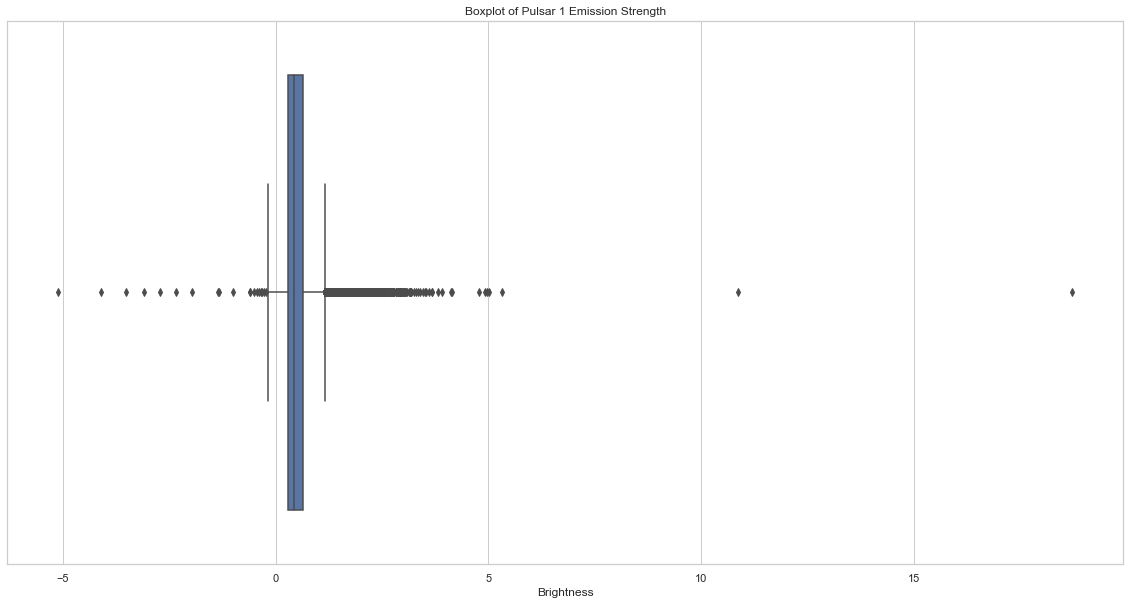

In [9]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=pulsar1["Brightness"]).set_title("Boxplot of Pulsar 1 Emission Strength")

##### Scatterplot
Looking at the scatterplot of Pulsar 1's brightness observations, there appears to be a random scatter, with two outliers, marked in yellow and green with readings of roughly 19 and 11 brightness, respectively.

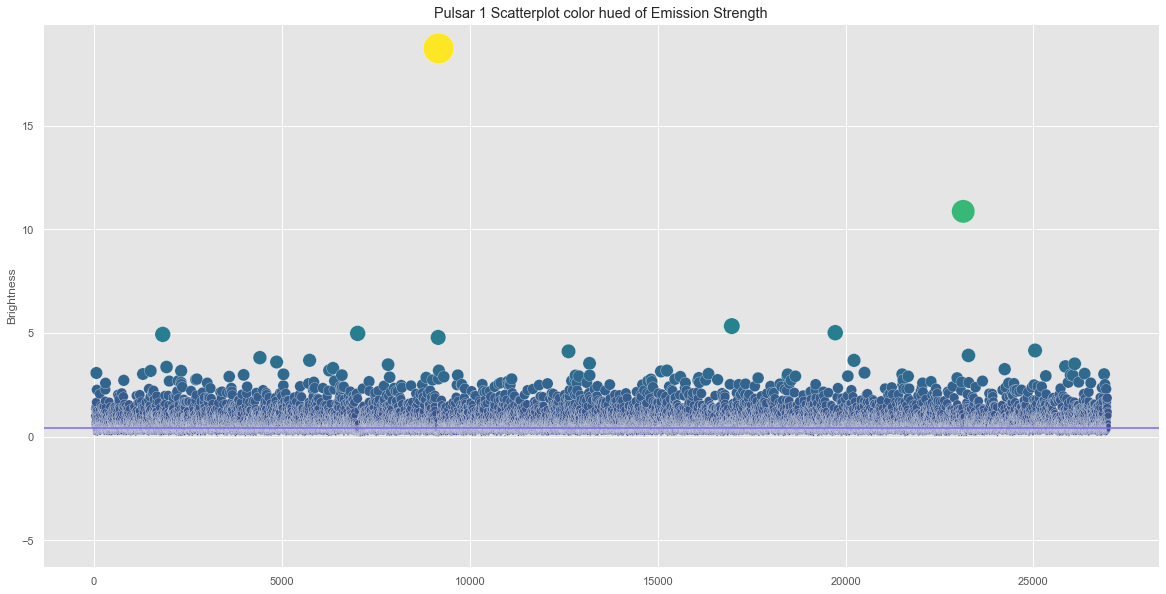

In [10]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar1.Brightness.values
plt.style.use('ggplot')
ax = sns.scatterplot(data=pulsar1["Brightness"], s= strength*50, c=strength, cmap="viridis", marker="o").set_title('Pulsar 1 Scatterplot color hued of Emission Strength')
ax= plt.axhline( y=pulsar1["Brightness"].median(), ls='-',c='mediumslateblue')

##### Distribution
Looking at the distribtuion of Pulsar 1's brightness, there appears to be a moderate positive skew with a peak around 0.4

Text(0.5, 1.0, 'Distribution of Pulsar 1 Brightness')

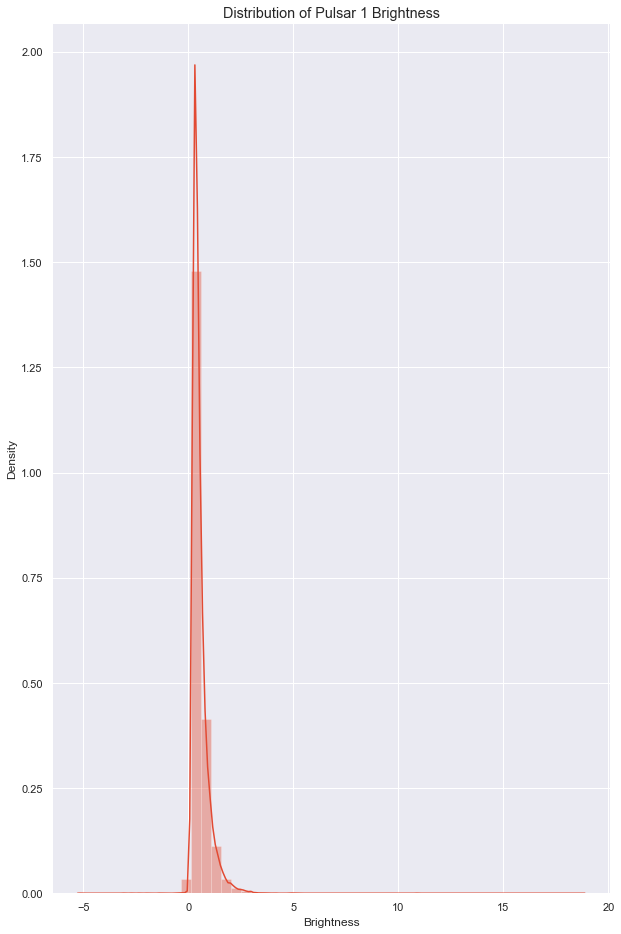

In [11]:
plt.figure(figsize=(10, 16))
with sns.axes_style('darkgrid'):
    sns.distplot(pulsar1.Brightness)
plt.title("Distribution of Pulsar 1 Brightness")

#### Pulsar 2 (J0953+0755):

In [12]:
obs, cols = pulsar2.shape
print("Number of Observations in Pulsar 2: ", obs)

Number of Observations in Pulsar 2:  14329


Having a look at the first 15 observations:

In [13]:
pulsar2.head(15)

Pulse Number  Brightness  Uncertainty
0              1    0.334330     0.015570
1              2   -0.098659     0.014051
2              3    0.123514     0.011901
3              4    0.443923     0.014365
4              5    1.590446     0.057785
5              6    1.233848     0.018692
6              7    0.857876     0.022208
7              8    0.254255     0.018185
8              9    0.292077     0.021672
9             10    0.439929     0.046293
10            11    0.824310     0.036243
11            12    1.443460     0.088372
12            13    0.127981     0.018070
13            14    0.327896     0.012362
14            15    2.473663     0.099205

##### Descriptive Statistics
Generating descriptive statistics for Brightness and Uncertainty variables

In [14]:
pulsar2.describe([], exclude=int)

Brightness   Uncertainty
count  14329.000000  14329.000000
mean       0.994458      0.034561
std        1.211127      0.029641
min       -0.219110      0.010120
50%        0.481894      0.021999
max        8.552022      0.242041

##### Null or missing values:
Checking for any null or missing values:

In [15]:
nullBoolBrightness2 = pd.isnull(pulsar2["Brightness"])

pulsar2[nullBoolBrightness2]

Empty DataFrame
Columns: [Pulse Number, Brightness, Uncertainty]
Index: []

In [16]:
if len(pulsar2[nullBoolBrightness2]) > 0:
    print("There are", len(pulsar2[nullBoolBrightness2]), "missing values for brightness")
else:
    print("There are no missing brightness values")

There are no missing brightness values


##### Boxplot
Looking at a boxplot of the brightness we can see that most values fall in the 0.2 to 1.5 range and a lot of large observations, but not quite outliers.

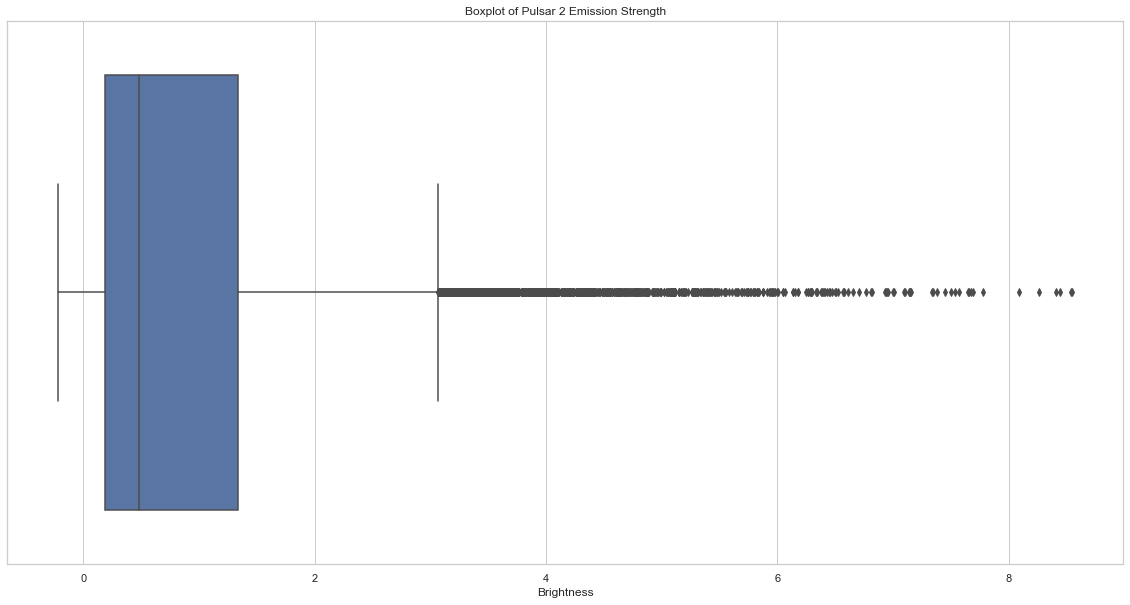

In [17]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=pulsar2["Brightness"]).set_title("Boxplot of Pulsar 2 Emission Strength")

##### Scatterplot
Looking at the scatterplot of Pulsar 2's brightness observations, there appears to be a random scatter

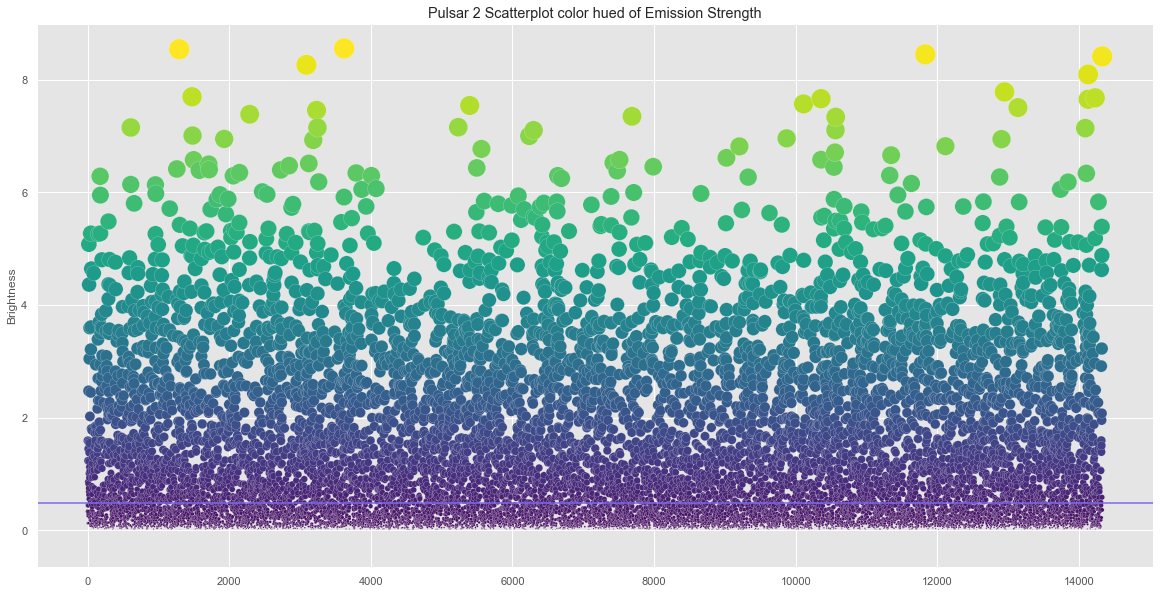

In [18]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar2.Brightness.values
plt.style.use('ggplot')
ax = sns.scatterplot(data=pulsar2["Brightness"], s= strength*50, c=strength, cmap="viridis", marker="o").set_title('Pulsar 2 Scatterplot color hued of Emission Strength')
ax= plt.axhline( y=pulsar2["Brightness"].median(), ls='-',c='mediumslateblue')

##### Distribution
Looking at the distribtuion of Pulsar 2's brightness, there appears to be a strong positive skew

Text(0.5, 1.0, 'Distribution of Pulsar 2 Brightness')

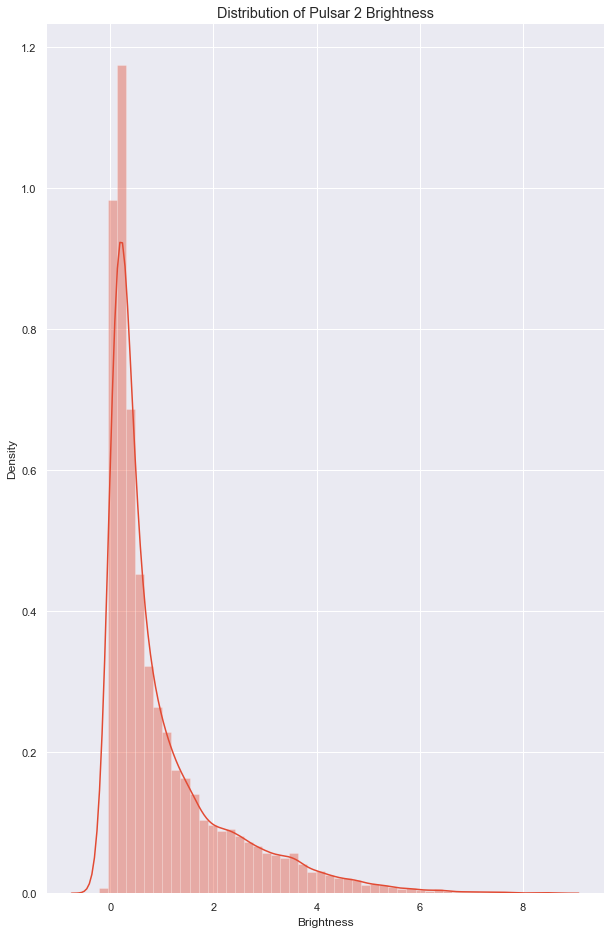

In [19]:
plt.figure(figsize=(10, 16))
with sns.axes_style('darkgrid'):
    sns.distplot(pulsar2.Brightness)
plt.title("Distribution of Pulsar 2 Brightness")

#### Pulsar 3 (J0835-4510):

In [20]:
obs, cols = pulsar3.shape
print("Number of Observations in Pulsar 3: ", obs)

Number of Observations in Pulsar 3:  1331


Having a look at the first 15 observations:

In [21]:
pulsar3.head(15)

Pulse Number  Brightness  Uncertainty
0              1    0.984043     0.053831
1              2    2.487928     0.048796
2              3    1.690295     0.025639
3              4    1.196142     0.039539
4              5    1.979783     0.041460
5              6    2.297645     0.054210
6              7    2.322135     0.043554
7              8    2.289047     0.049957
8              9    2.442574     0.025110
9             10    2.136332     0.022712
10            11    1.976790     0.037551
11            12    2.445764     0.047004
12            13    1.937017     0.028561
13            14    2.315184     0.045216
14            15    2.584888     0.040232

##### Descriptive Statistics
Generating descriptive statistics for Brightness and Uncertainty variables

In [22]:
pulsar3.describe([], exclude=int)

Brightness  Uncertainty
count  1331.000000  1331.000000
mean      2.248107     0.039495
std       0.591161     0.013056
min       0.633413     0.012888
50%       2.255182     0.037513
max       4.050718     0.098902

##### Null or missing values:
Checking for any null or missing values:

In [23]:
nullBoolBrightness3 = pd.isnull(pulsar3["Brightness"])

pulsar3[nullBoolBrightness3]

Empty DataFrame
Columns: [Pulse Number, Brightness, Uncertainty]
Index: []

In [24]:
if len(pulsar3[nullBoolBrightness3]) > 0:
    print("There are", len(pulsar3[nullBoolBrightness3]), "missing values for brightness")
else:
    print("There are no missing brightness values")

There are no missing brightness values


##### Boxplot
Looking at a boxplot of the brightness we can see that most values are within the 1.8 to 2.7 range, but once again no obvious outliers present

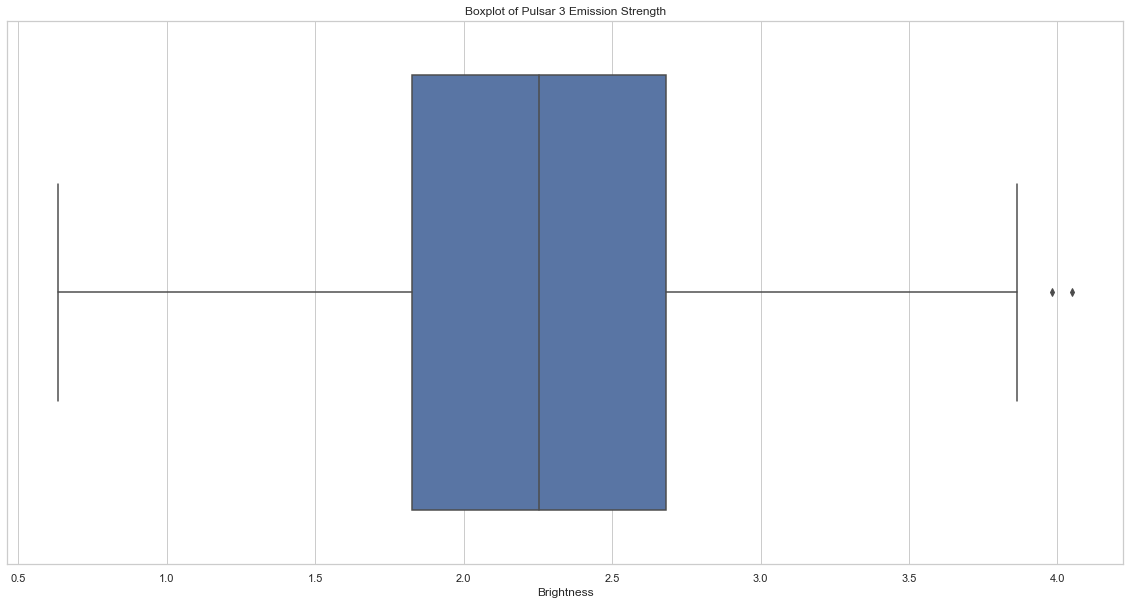

In [25]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=pulsar3["Brightness"]).set_title("Boxplot of Pulsar 3 Emission Strength")

##### Scatterplot
Looking at the scatterplot of Pulsar 3's brightness observations, there appears to be no discernable pattern, that is, it appears to be a random scatter

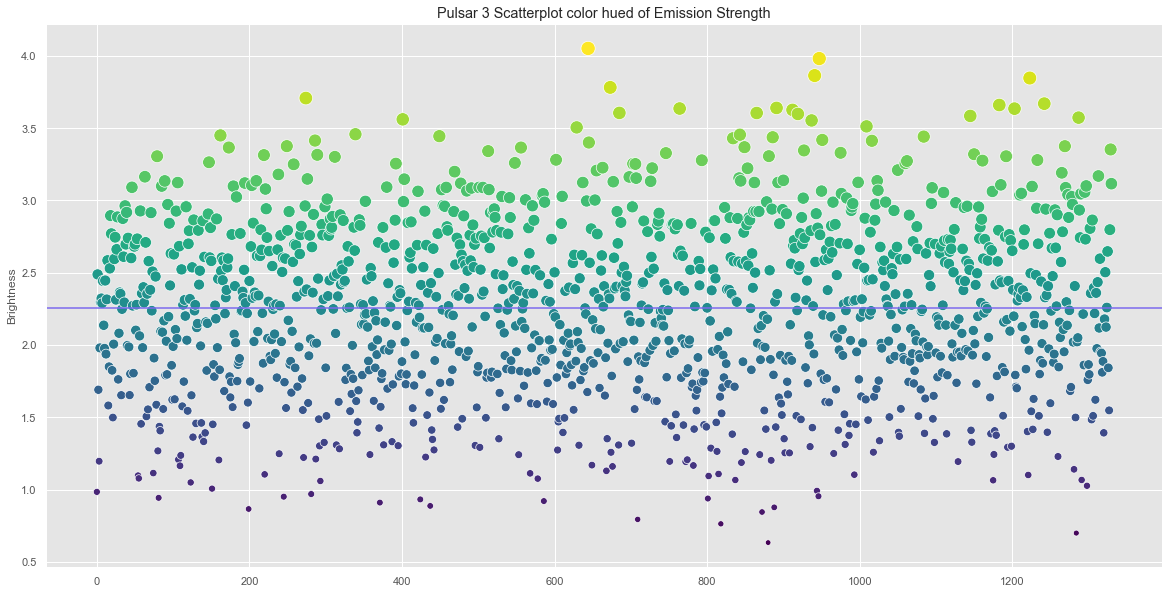

In [26]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar3.Brightness.values
plt.style.use('ggplot')
ax = sns.scatterplot(data=pulsar3["Brightness"], s= strength*50, c=strength, cmap="viridis", marker="o").set_title('Pulsar 3 Scatterplot color hued of Emission Strength')
ax= plt.axhline( y=pulsar3["Brightness"].median(), ls='-',c='mediumslateblue')

##### Swarm Plot

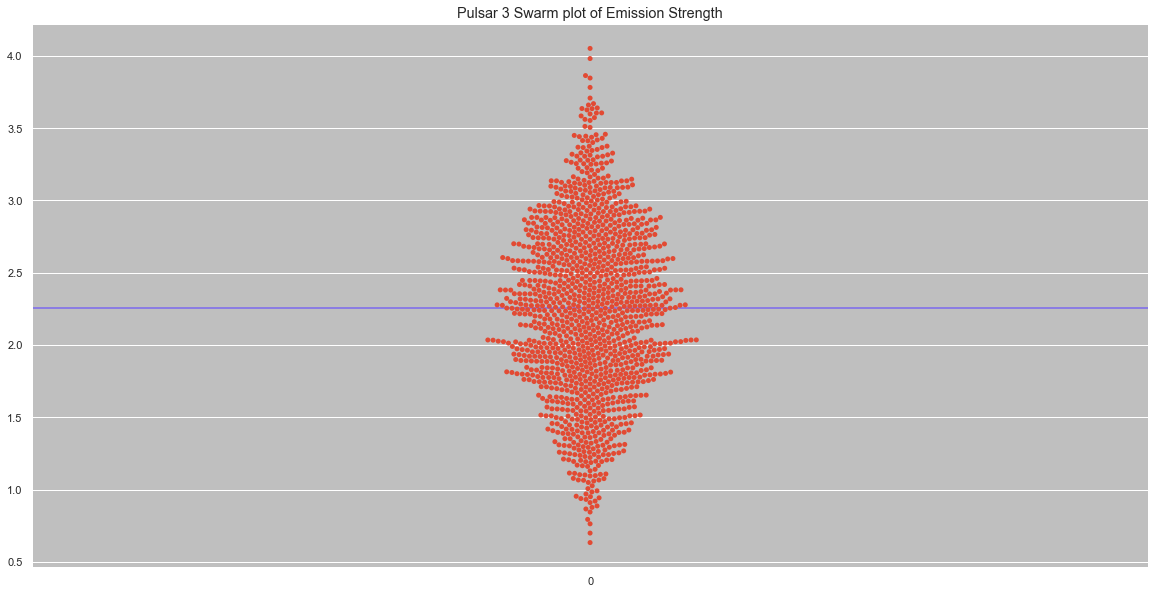

In [27]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar3.Brightness.values
ax = plt.axhline( y=pulsar3["Brightness"].median(), ls='-',c='mediumslateblue')
ax = sns.swarmplot(data=pulsar3["Brightness"], c="blue").set_title('Pulsar 3 Swarm plot of Emission Strength')

##### Distribution
Looking at the distribtuion of Pulsar 3's brightness, it appears to follow very closely to a normal distribution, however it does appear to be bimodal.

Text(0.5, 1.0, 'Distribution of Pulsar 3 Brightness')

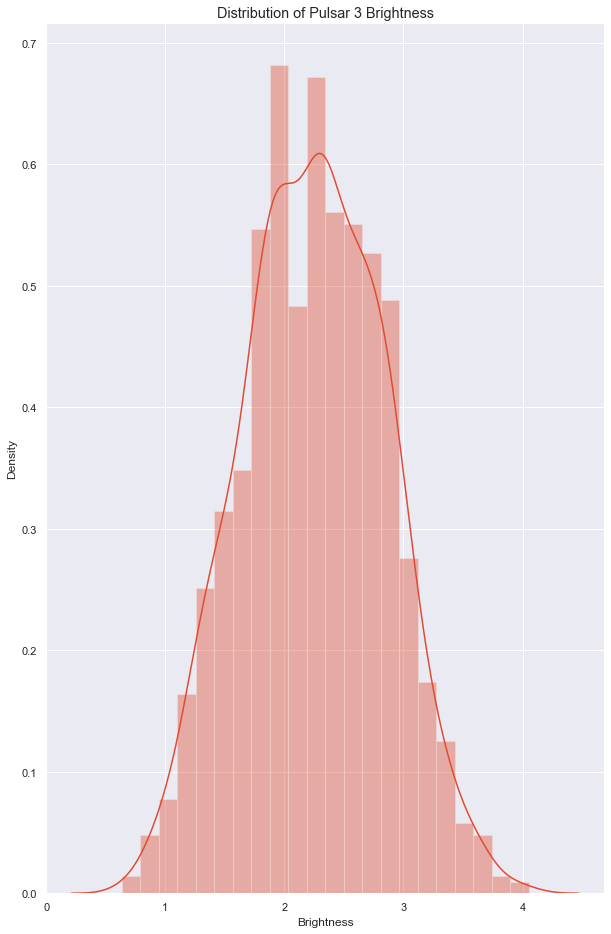

In [28]:
plt.figure(figsize=(10, 16))
with sns.axes_style('darkgrid'):
    sns.distplot(pulsar3.Brightness)
plt.title("Distribution of Pulsar 3 Brightness")

#### Pulsar 4 (J1243-6423):

In [29]:
obs, cols = pulsar4.shape
print("Number of Observations in Pulsar 4: ", obs)

Number of Observations in Pulsar 4:  1819


Having a look at the first 15 observations:

In [30]:
pulsar4.head(15)

Pulse Number  Brightness  Uncertainty
0              1    0.101127     0.001893
1              2    0.012166     0.001814
2              3    0.021918     0.001835
3              4    0.181179     0.002183
4              5    0.000240     0.001725
5              6    0.085866     0.001723
6              7    0.067280     0.001778
7              8    0.092884     0.002438
8              9    0.083350     0.002101
9             10    0.087871     0.001941
10            11    0.123529     0.002026
11            12    0.097413     0.001878
12            13    0.100649     0.001820
13            14    0.058025     0.001724
14            15    0.116164     0.001948

##### Descriptive Statistics
Generating descriptive statistics for Brightness and Uncertainty variables

In [31]:
pulsar4.describe([], exclude=int)

Brightness  Uncertainty
count  1819.000000  1819.000000
mean      0.075070     0.001958
std       0.057006     0.000306
min      -0.004643     0.001532
50%       0.076660     0.001872
max       0.269903     0.005952

##### Null or missing values:
Checking for any null or missing values:

In [32]:
nullBoolBrightness4 = pd.isnull(pulsar4["Brightness"])

pulsar4[nullBoolBrightness4]

Empty DataFrame
Columns: [Pulse Number, Brightness, Uncertainty]
Index: []

In [33]:
if len(pulsar4[nullBoolBrightness4]) > 0:
    print("There are", len(pulsar4[nullBoolBrightness4]), "missing values for brightness")
else:
    print("There are no missing brightness values")

There are no missing brightness values


##### Boxplot
Looking at a boxplot of the brightness we can see that most values fall within the 0.02 to 0.12 range, with no extreme outliers

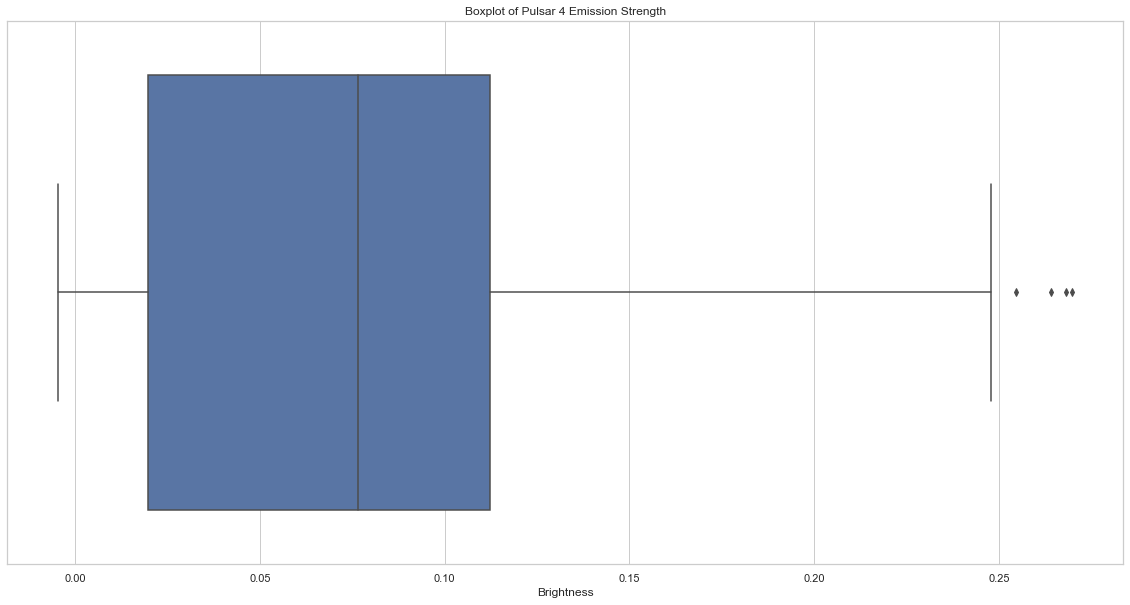

In [34]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=pulsar4["Brightness"]).set_title("Boxplot of Pulsar 4 Emission Strength")

##### Scatterplot
Looking at the scatterplot of Pulsar 4's brightness observations, there is no visible pattern in the data, lending to the idea that it appears random

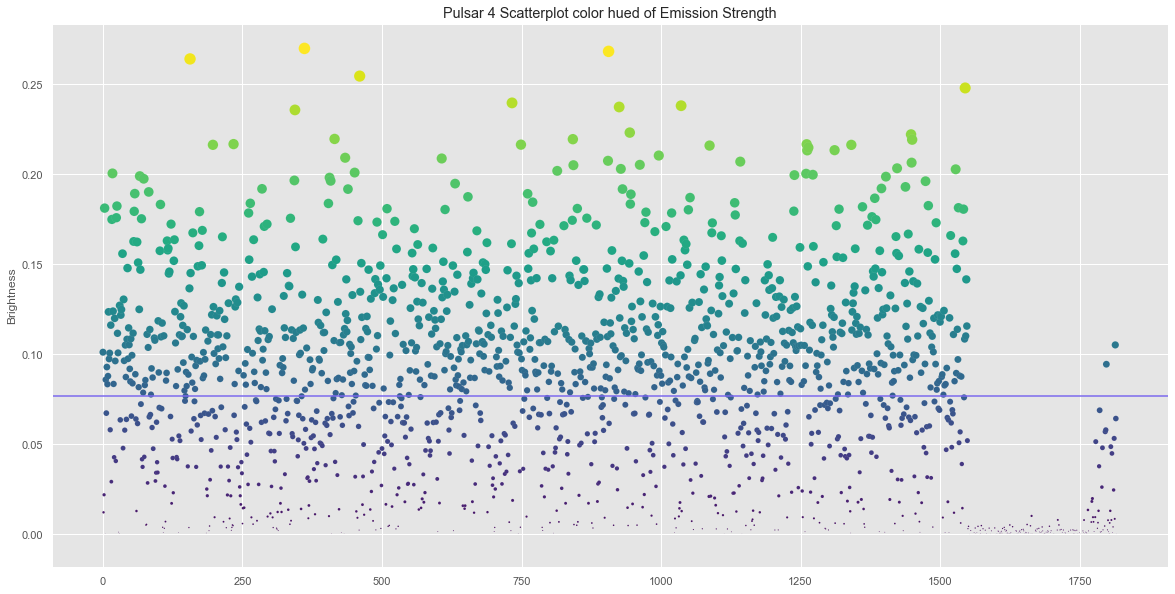

In [35]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar4.Brightness.values
plt.style.use('ggplot')
ax = sns.scatterplot(data=pulsar4["Brightness"], s= strength*500, c=strength, cmap="viridis", marker="o").set_title('Pulsar 4 Scatterplot color hued of Emission Strength')
ax= plt.axhline( y=pulsar4["Brightness"].median(), ls='-',c='mediumslateblue')

##### Swarm Plot

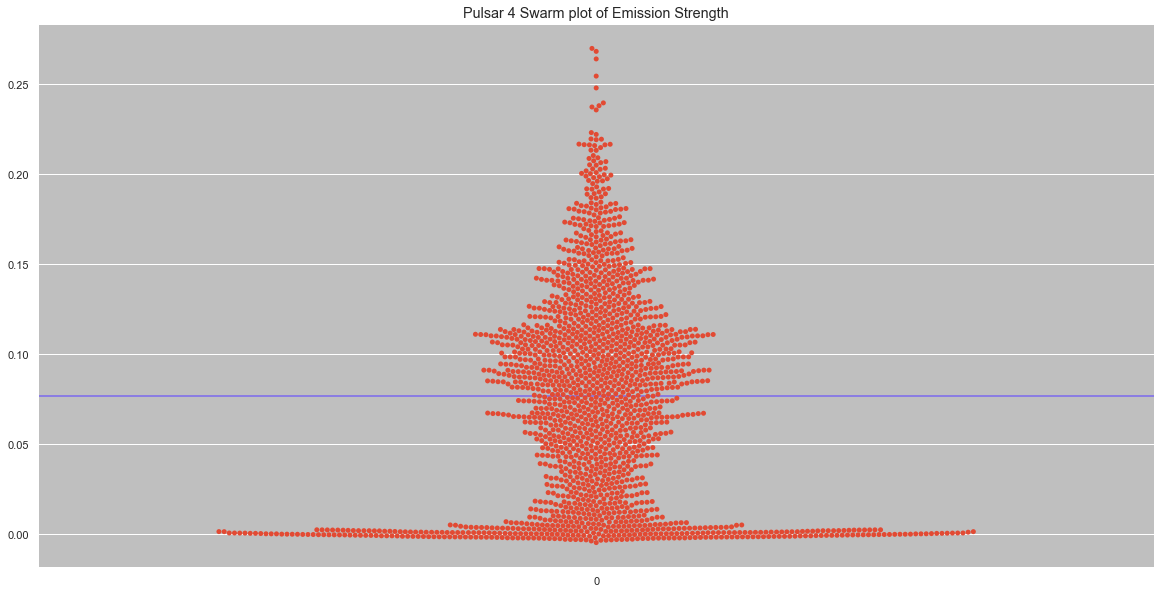

In [36]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar4.Brightness.values
ax = plt.axhline( y=pulsar4["Brightness"].median(), ls='-',c='mediumslateblue')
ax = sns.swarmplot(data=pulsar4["Brightness"], c="blue").set_title('Pulsar 4 Swarm plot of Emission Strength')

##### Distribution
Looking at the distribtuion of Pulsar 4's brightness, it is bimodal with a moderate positive skew

Text(0.5, 1.0, 'Distribution of Pulsar 4 Brightness')

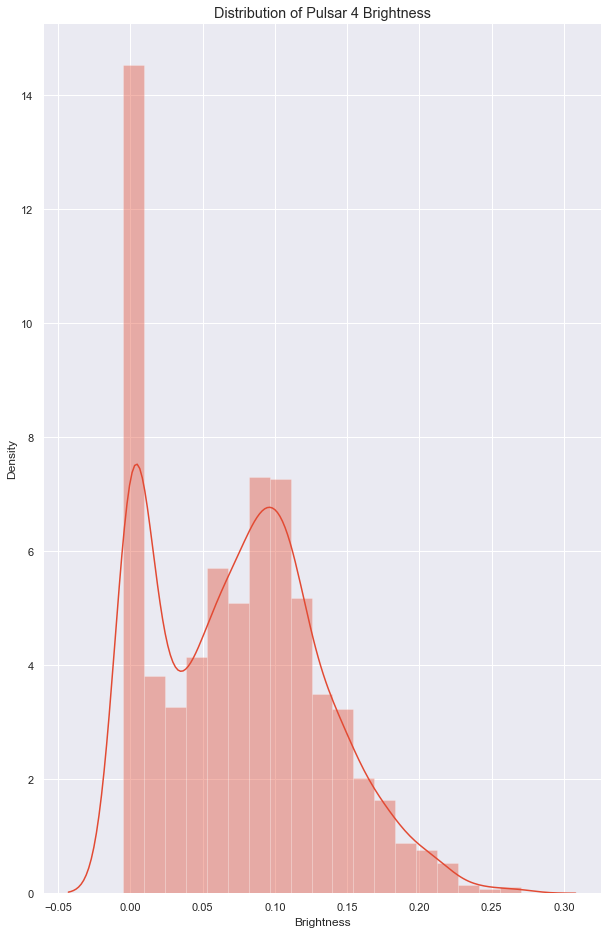

In [37]:
plt.figure(figsize=(10, 16))
with sns.axes_style('darkgrid'):
    sns.distplot(pulsar4.Brightness)
plt.title("Distribution of Pulsar 4 Brightness")

#### Pulsar 5 (J1456-6843):

In [38]:
obs, cols = pulsar5.shape
print("Number of Observations in Pulsar 5: ", obs)

Number of Observations in Pulsar 5:  1219


Having a look at the first 15 observations:

In [39]:
pulsar5.head(15)

Pulse Number  Brightness  Uncertainty
0              1    0.053904     0.005560
1              2    0.058653     0.004821
2              3    0.110208     0.005196
3              4    0.034716     0.004729
4              5    0.056101     0.004619
5              6    0.046168     0.005074
6              7    0.055648     0.004916
7              8    0.060890     0.004581
8              9    0.024388     0.004922
9             10    0.039370     0.004633
10            11    0.009141     0.004581
11            12    0.145273     0.005053
12            13    0.039953     0.004938
13            14   -0.002554     0.004409
14            15    0.035696     0.004903

##### Descriptive Statistics
Generating descriptive statistics for Brightness and Uncertainty variables

In [40]:
pulsar5.describe([], exclude=int)

Brightness  Uncertainty
count  1219.000000  1219.000000
mean      0.104176     0.005410
std       0.081916     0.001282
min      -0.007285     0.001075
50%       0.081228     0.004966
max       0.825366     0.016201

##### Null or missing values:
Checking for any null or missing values:

In [41]:
nullBoolBrightness5 = pd.isnull(pulsar5["Brightness"])

pulsar5[nullBoolBrightness5]

Empty DataFrame
Columns: [Pulse Number, Brightness, Uncertainty]
Index: []

In [42]:
if len(pulsar5[nullBoolBrightness5]) > 0:
    print("There are", len(pulsar5[nullBoolBrightness5]), "missing values for brightness")
else:
    print("There are no missing brightness values")

There are no missing brightness values


##### Boxplot
Looking at a boxplot of the brightness we can see that most values fall within the 0.05 to 0.15 range, with an outlier around 0.82

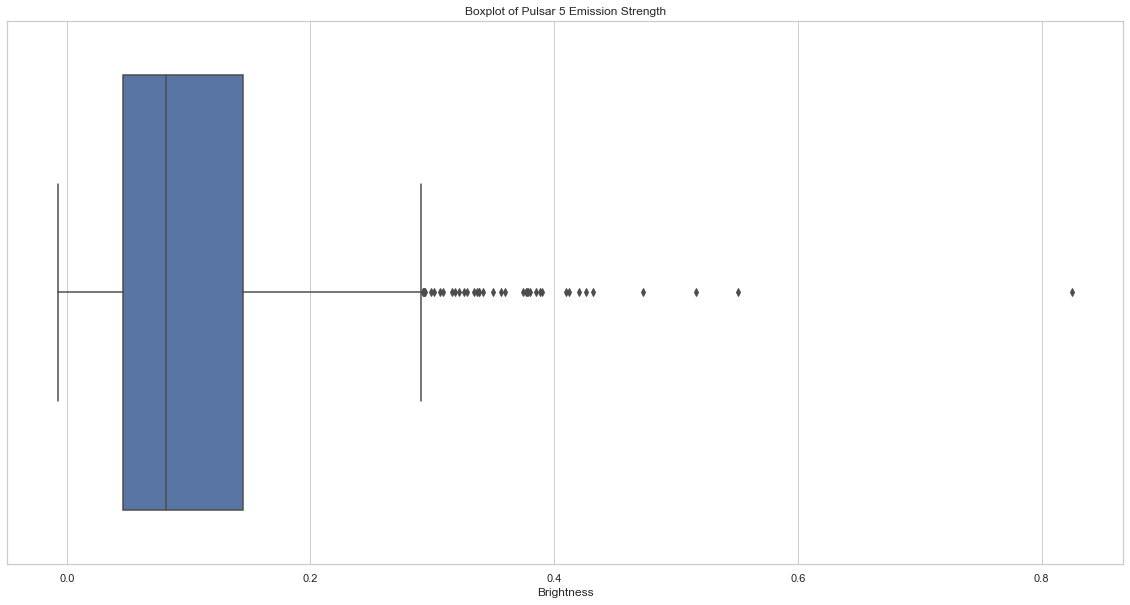

In [43]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=pulsar5["Brightness"]).set_title("Boxplot of Pulsar 5 Emission Strength")

##### Scatterplot
Looking at the scatterplot of Pulsar 5's brightness observations, there appears to be a random scatter

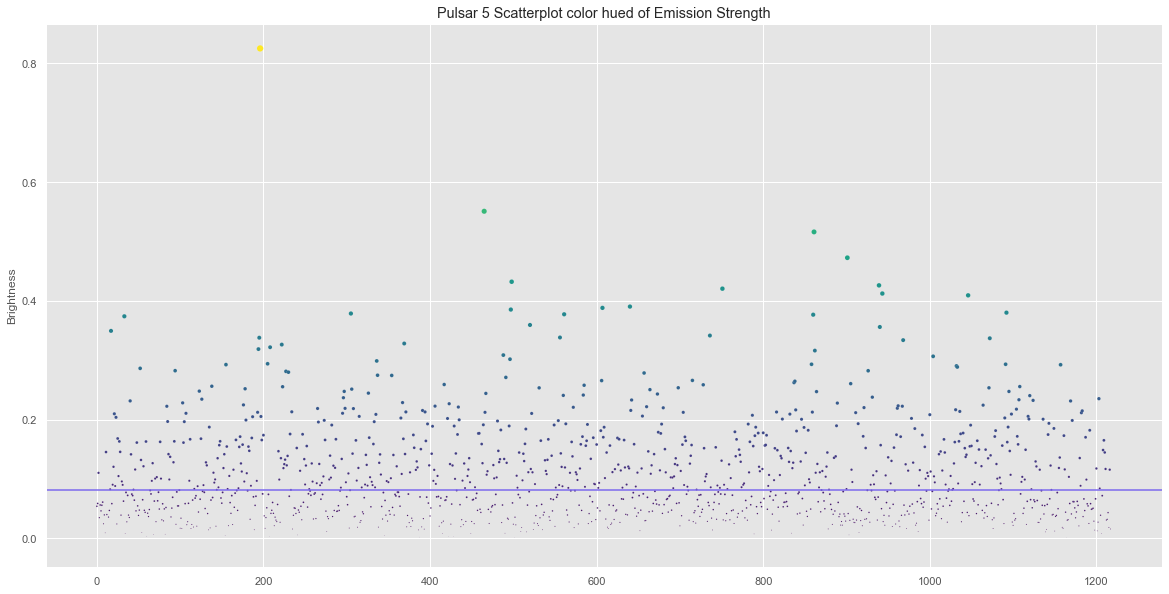

In [44]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar5.Brightness.values
plt.style.use('ggplot')
ax = sns.scatterplot(data=pulsar5["Brightness"], s= strength*50, c=strength, cmap="viridis", marker="o").set_title('Pulsar 5 Scatterplot color hued of Emission Strength')
ax= plt.axhline( y=pulsar5["Brightness"].median(), ls='-',c='mediumslateblue')

##### Swarm Plot

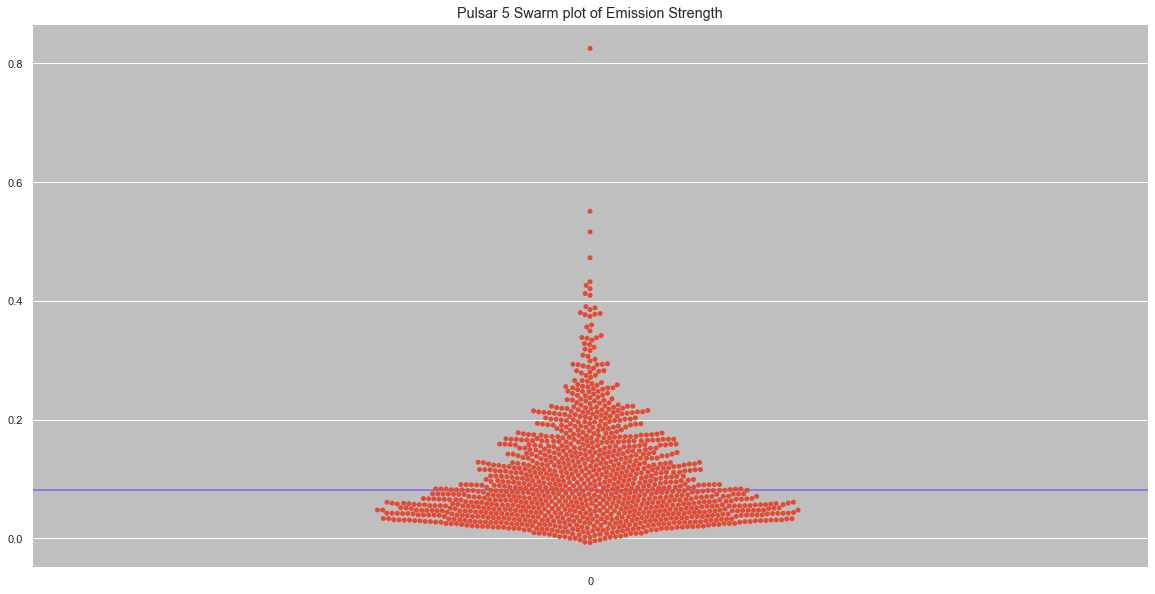

In [45]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar5.Brightness.values
ax = plt.axhline( y=pulsar5["Brightness"].median(), ls='-',c='mediumslateblue')
ax = sns.swarmplot(data=pulsar5["Brightness"], c="blue").set_title('Pulsar 5 Swarm plot of Emission Strength')

##### Distribution
Looking at the distribtuion of Pulsar 5's brightness, there is a strong positive skew, with a peak around 0.05

Text(0.5, 1.0, 'Distribution of Pulsar 5 Brightness')

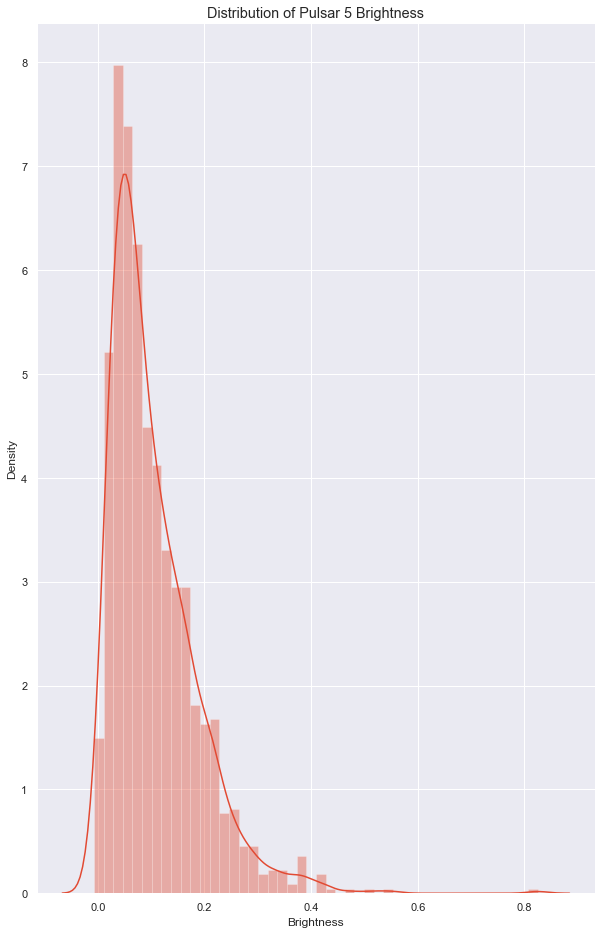

In [46]:
plt.figure(figsize=(10, 16))
with sns.axes_style('darkgrid'):
    sns.distplot(pulsar5.Brightness)
plt.title("Distribution of Pulsar 5 Brightness")

#### Pulsar 6 (J1644-4559):

In [47]:
obs, cols = pulsar6.shape
print("Number of Observations in Pulsar 6: ", obs)

Number of Observations in Pulsar 6:  698


Having a look at the first 15 observations:

In [48]:
pulsar6.head(15)

Pulse Number  Brightness  Uncertainty
0              1    0.634671     0.002761
1              2    0.736945     0.005207
2              3    0.693834     0.002706
3              4    1.021866     0.010184
4              5    0.673845     0.006236
5              6    0.676883     0.004763
6              7    0.527039     0.002422
7              8    0.673417     0.003174
8              9    0.357076     0.002848
9             10    0.661704     0.005588
10            11    0.545564     0.003835
11            12    0.494655     0.003145
12            13    0.804260     0.005258
13            14    0.513362     0.005700
14            15    0.477025     0.002945

##### Descriptive Statistics
Generating descriptive statistics for Brightness and Uncertainty variables

In [49]:
pulsar6.describe([], exclude=int)

Brightness  Uncertainty
count  698.000000   698.000000
mean     0.654319     0.004445
std      0.163945     0.001855
min      0.007642     0.002129
50%      0.658295     0.003951
max      1.159334     0.016097

##### Null or missing values:
Checking for any null or missing values:

In [50]:
nullBoolBrightness6 = pd.isnull(pulsar6["Brightness"])

pulsar6[nullBoolBrightness6]

Empty DataFrame
Columns: [Pulse Number, Brightness, Uncertainty]
Index: []

In [51]:
if len(pulsar6[nullBoolBrightness6]) > 0:
    print("There are", len(pulsar6[nullBoolBrightness6]), "missing values for brightness")
else:
    print("There are no missing brightness values")

There are no missing brightness values


##### Boxplot
Looking at a boxplot of the brightness we can see that most values are within 0.5 to 0.7, with no obvious outliers to be removed

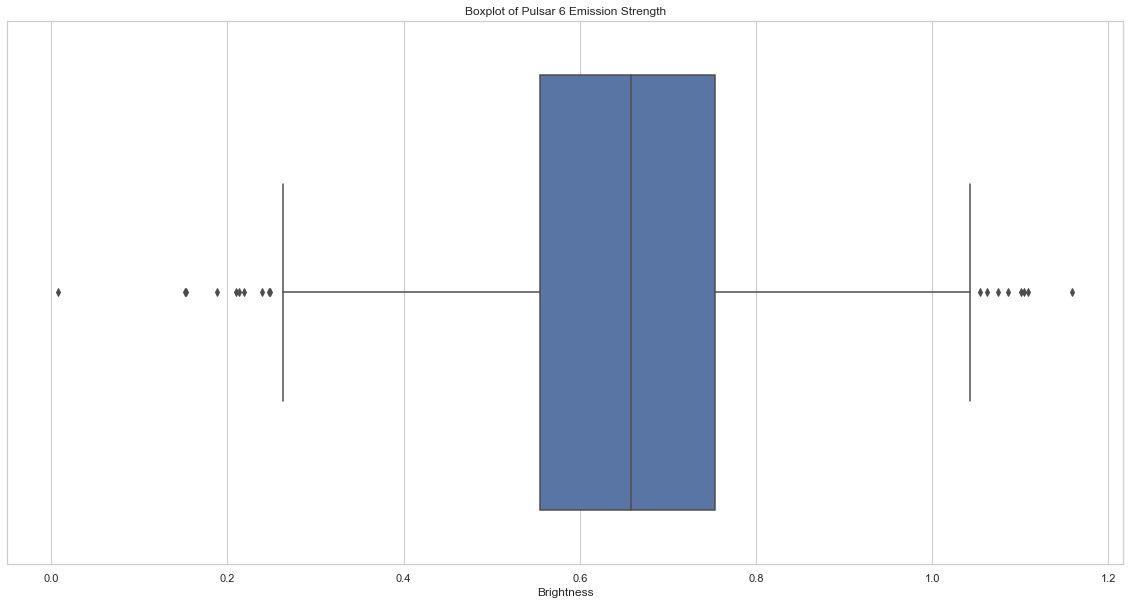

In [52]:
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=pulsar6["Brightness"]).set_title("Boxplot of Pulsar 6 Emission Strength")

##### Scatterplot
Looking at the scatterplot of Pulsar 6's brightness observations, there brightness appears to have a random scatter, with no pattern distinguishable

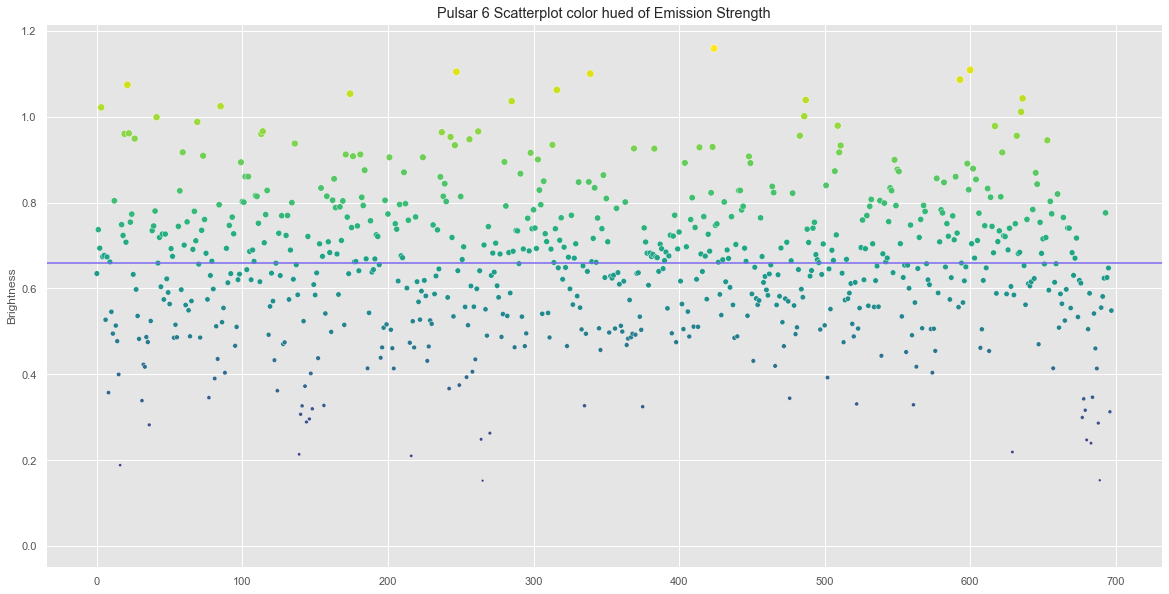

In [53]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar6.Brightness.values
plt.style.use('ggplot')
ax = sns.scatterplot(data=pulsar6["Brightness"], s= strength*50, c=strength, cmap="viridis", marker="o").set_title('Pulsar 6 Scatterplot color hued of Emission Strength')
ax= plt.axhline( y=pulsar6["Brightness"].median(), ls='-',c='mediumslateblue')

##### Swarm Plot

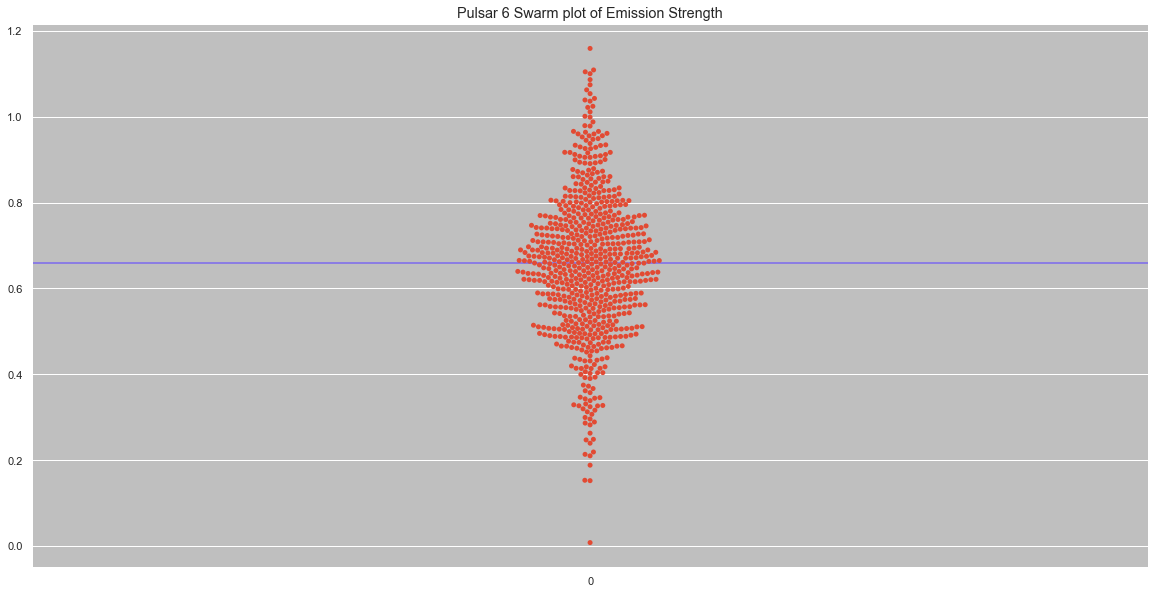

In [54]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid", {"axes.facecolor": ".75"})
strength = pulsar6.Brightness.values
ax = plt.axhline( y=pulsar6["Brightness"].median(), ls='-',c='mediumslateblue')
ax = sns.swarmplot(data=pulsar6["Brightness"], c="blue").set_title('Pulsar 6 Swarm plot of Emission Strength')

##### Distribution
Looking at the distribtuion of Pulsar 6's brightness, it appears very closely follow a normal distribution

Text(0.5, 1.0, 'Distribution of Pulsar 6 Brightness')

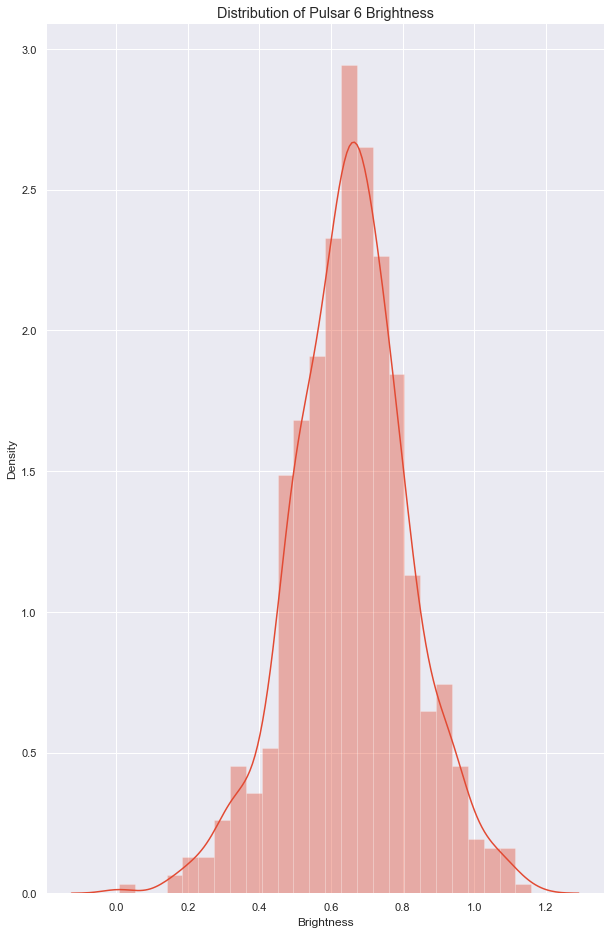

In [55]:
plt.figure(figsize=(10, 16))
with sns.axes_style('darkgrid'):
    sns.distplot(pulsar6.Brightness)
plt.title("Distribution of Pulsar 6 Brightness")

### Generating a Binary Data Sequence for Machine Learning Algorithms and Randomness Testing

A 'Binary' column is generated based on whether the Brightness for the current observation is higher or lower than the median Brightness. If the observed Brightness is greater than the median, assign 1, if less than, assign 0.

#### Pulsar 1 (J0437-4715):

In [56]:
medianpulse1 = pulsar1["Brightness"].median()
print("Median of Pulsar 1: ", medianpulse1)
pulsar1['Binary'] = np.where(pulsar1['Brightness'] > medianpulse1, 1, 0)

Median of Pulsar 1:  0.42381595


In [57]:
pulsar1.head(10)

Pulse Number  Brightness  Uncertainty  Binary
0             1    0.598393     0.056431       1
1             2    0.590859     0.055182       1
2             3    0.449643     0.063632       1
3             4    0.682860     0.056269       1
4             5    0.490026     0.046830       1
5             6    0.586071     0.052649       1
6             7    0.150353     0.056483       0
7             8    0.384684     0.052567       0
8             9    0.429094     0.055569       1
9            10    0.995865     0.075811       1

In [58]:
print("Number of observations assigned 1: ", len(pulsar1[(pulsar1.Brightness > medianpulse1)]))
print("Number of observations assigned 0: ", len(pulsar1[(pulsar1.Brightness < medianpulse1)]))

Number of observations assigned 1:  13500
Number of observations assigned 0:  13500


#### Pulsar 2 (J0953+0755):

In [59]:
medianpulse2 = pulsar2["Brightness"].median()
print("Median of Pulsar 2: ", medianpulse2)
pulsar2['Binary'] = np.where(pulsar2['Brightness'] > medianpulse2, 1, 0)

Median of Pulsar 2:  0.4818942


In [60]:
pulsar2.head(10)

Pulse Number  Brightness  Uncertainty  Binary
0             1    0.334330     0.015570       0
1             2   -0.098659     0.014051       0
2             3    0.123514     0.011901       0
3             4    0.443923     0.014365       0
4             5    1.590446     0.057785       1
5             6    1.233848     0.018692       1
6             7    0.857876     0.022208       1
7             8    0.254255     0.018185       0
8             9    0.292077     0.021672       0
9            10    0.439929     0.046293       0

In [61]:
print("Number of observations assigned 1: ", len(pulsar2[(pulsar2.Brightness > medianpulse2)]))
print("Number of observations assigned 0: ", len(pulsar2[(pulsar2.Brightness < medianpulse2)]))

Number of observations assigned 1:  7164
Number of observations assigned 0:  7164


#### Pulsar 3 (J0835-4510):

In [62]:
medianpulse3 = pulsar3["Brightness"].median()
print("Median of Pulsar 3: ", medianpulse3)
pulsar3['Binary'] = np.where(pulsar3['Brightness'] > medianpulse3, 1, 0)

Median of Pulsar 3:  2.255182


In [63]:
pulsar3.head(10)

Pulse Number  Brightness  Uncertainty  Binary
0             1    0.984043     0.053831       0
1             2    2.487928     0.048796       1
2             3    1.690295     0.025639       0
3             4    1.196142     0.039539       0
4             5    1.979783     0.041460       0
5             6    2.297645     0.054210       1
6             7    2.322135     0.043554       1
7             8    2.289047     0.049957       1
8             9    2.442574     0.025110       1
9            10    2.136332     0.022712       0

In [64]:
print("Number of observations assigned 1: ", len(pulsar3[(pulsar3.Brightness > medianpulse3)]))
print("Number of observations assigned 0: ", len(pulsar3[(pulsar3.Brightness < medianpulse3)]))

Number of observations assigned 1:  665
Number of observations assigned 0:  665


#### Pulsar 4 (J1243-6423):

In [65]:
medianpulse4 = pulsar4["Brightness"].median()
print("Median of Pulsar 4: ", medianpulse4)
pulsar4['Binary'] = np.where(pulsar4['Brightness'] > medianpulse4, 1, 0)

Median of Pulsar 4:  0.07665979


In [66]:
pulsar4.head(10)

Pulse Number  Brightness  Uncertainty  Binary
0             1    0.101127     0.001893       1
1             2    0.012166     0.001814       0
2             3    0.021918     0.001835       0
3             4    0.181179     0.002183       1
4             5    0.000240     0.001725       0
5             6    0.085866     0.001723       1
6             7    0.067280     0.001778       0
7             8    0.092884     0.002438       1
8             9    0.083350     0.002101       1
9            10    0.087871     0.001941       1

In [67]:
print("Number of observations assigned 1: ", len(pulsar4[(pulsar4.Brightness > medianpulse4)]))
print("Number of observations assigned 0: ", len(pulsar4[(pulsar4.Brightness < medianpulse4)]))

Number of observations assigned 1:  909
Number of observations assigned 0:  909


#### Pulsar 5 (J1456-6843):

In [68]:
medianpulse5 = pulsar5["Brightness"].median()
print("Median of Pulsar 5: ", medianpulse5)
pulsar5['Binary'] = np.where(pulsar5['Brightness'] > medianpulse4, 1, 0)

Median of Pulsar 5:  0.081228


In [69]:
pulsar5.head(10)

Pulse Number  Brightness  Uncertainty  Binary
0             1    0.053904     0.005560       0
1             2    0.058653     0.004821       0
2             3    0.110208     0.005196       1
3             4    0.034716     0.004729       0
4             5    0.056101     0.004619       0
5             6    0.046168     0.005074       0
6             7    0.055648     0.004916       0
7             8    0.060890     0.004581       0
8             9    0.024388     0.004922       0
9            10    0.039370     0.004633       0

In [70]:
print("Number of observations assigned 1: ", len(pulsar5[(pulsar5.Brightness > medianpulse5)]))
print("Number of observations assigned 0: ", len(pulsar5[(pulsar5.Brightness < medianpulse5)]))

Number of observations assigned 1:  609
Number of observations assigned 0:  609


#### Pulsar 6 (J1644-4559):

In [71]:
medianpulse6 = pulsar6["Brightness"].median()
print("Median of Pulsar 6: ", medianpulse6)
pulsar6['Binary'] = np.where(pulsar6['Brightness'] > medianpulse6, 1, 0)

Median of Pulsar 6:  0.65829515


In [72]:
pulsar6.head(10)

Pulse Number  Brightness  Uncertainty  Binary
0             1    0.634671     0.002761       0
1             2    0.736945     0.005207       1
2             3    0.693834     0.002706       1
3             4    1.021866     0.010184       1
4             5    0.673845     0.006236       1
5             6    0.676883     0.004763       1
6             7    0.527039     0.002422       0
7             8    0.673417     0.003174       1
8             9    0.357076     0.002848       0
9            10    0.661704     0.005588       1

In [73]:
print("Number of observations assigned 1: ", len(pulsar6[(pulsar6.Brightness > medianpulse6)]))
print("Number of observations assigned 0: ", len(pulsar6[(pulsar6.Brightness < medianpulse6)]))

Number of observations assigned 1:  349
Number of observations assigned 0:  349


### Deriving Rolling Median and Mean statistics. With Binned Visualisations

#### Pulsar 1 (J0437-4715):

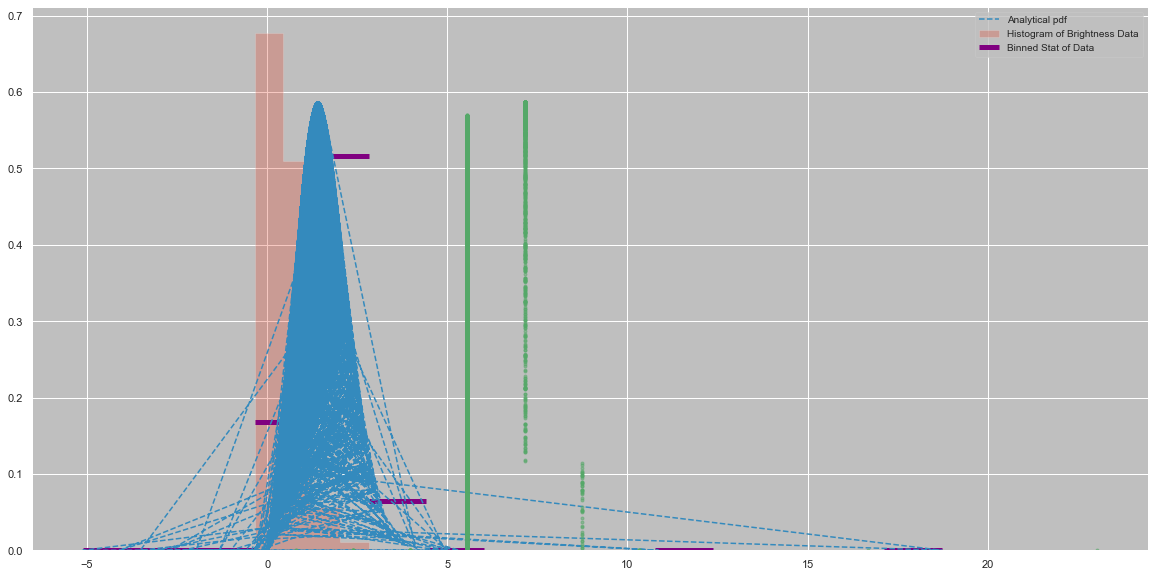

In [74]:
data = pulsar1["Brightness"]
dataPDF = stats.maxwell.pdf(data)
bin_means, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='mean', bins=15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, '--', label = "Analytical pdf")
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='purple', lw=5, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

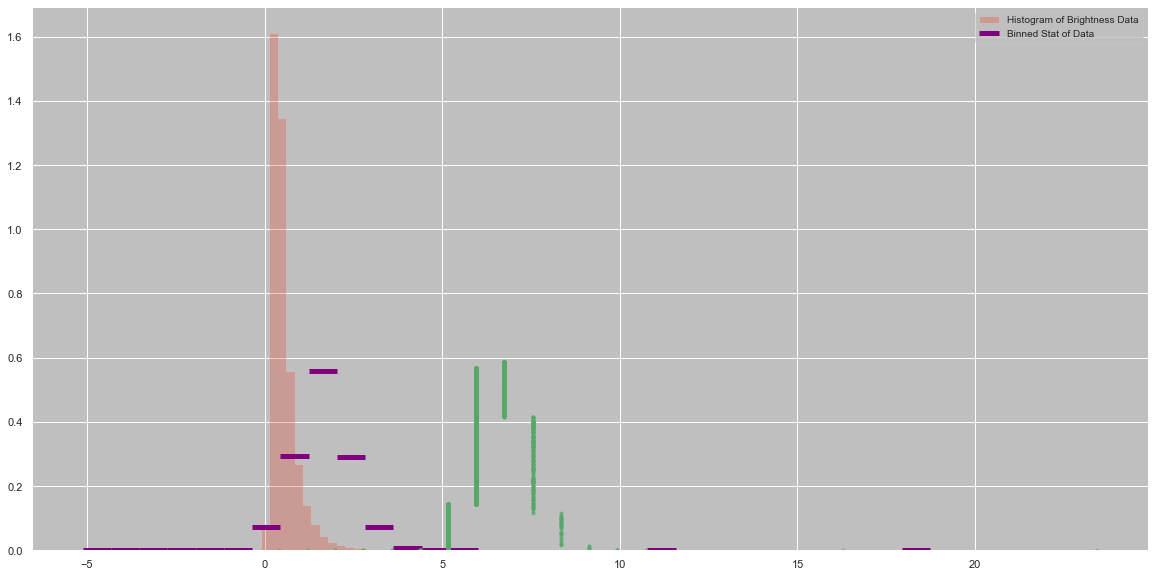

In [75]:
dataPDF = stats.maxwell.pdf(data)
bin_means, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='mean', bins=30)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='purple', lw=5, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

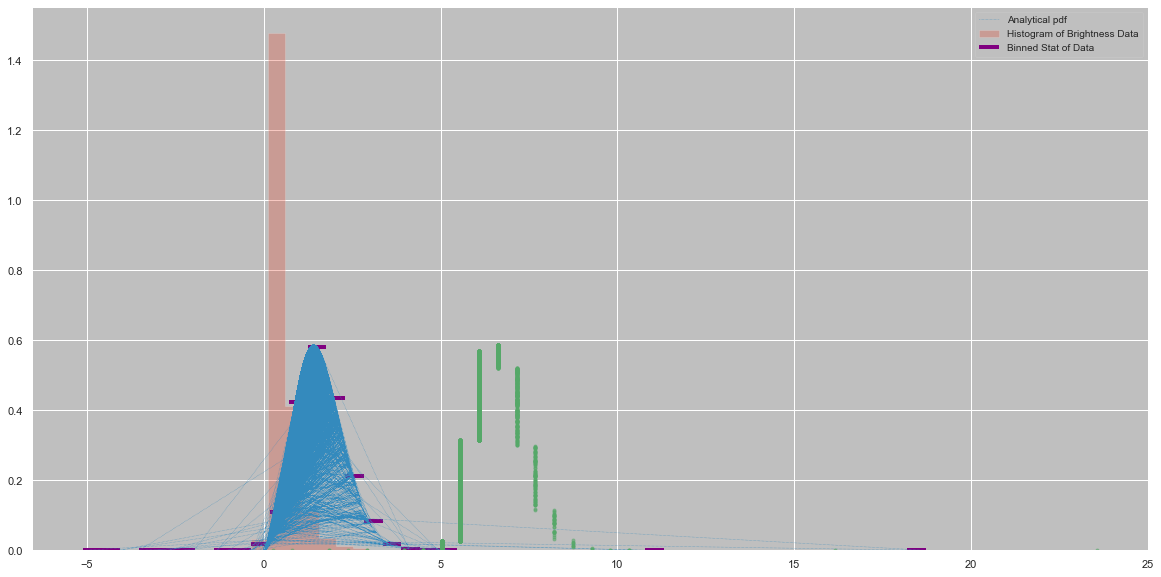

In [76]:
bin_median, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='median', bins=45)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=50, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, ':', label = "Analytical pdf", lw=0.5)
plt.hlines(bin_median, bin_edges[:-1], bin_edges[1:], colors='purple', lw=4, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

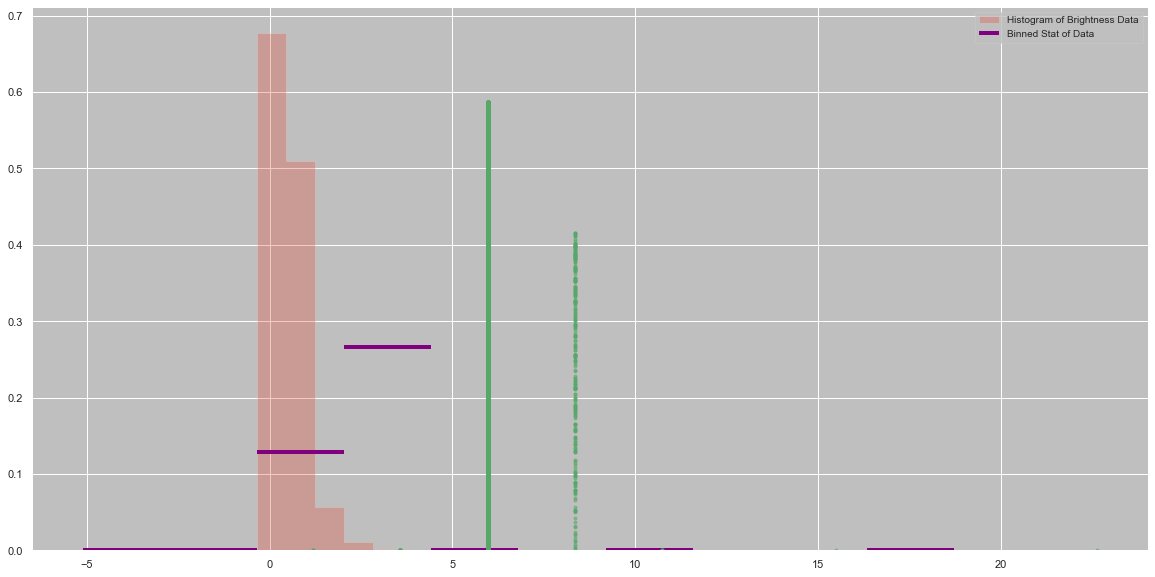

In [77]:
bin_median, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='median', bins=10)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.hlines(bin_median, bin_edges[:-1], bin_edges[1:], colors='purple', lw=4, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

Here we begin to add in the moving averages for further potential data work

In [78]:
pulsar1['RollingMeanEmissions5ths'] = pulsar1["Brightness"].rolling(5).mean()
pulsar1['RollingMeanEmissions10ths'] = pulsar1["Brightness"].rolling(10).mean()
pulsar1['RollingMedianEmissions5ths'] = pulsar1["Brightness"].rolling(5).median()
pulsar1['RollingMedianEmissions10ths'] = pulsar1["Brightness"].rolling(10).median()
pulsar1.head(15)

Pulse Number  Brightness  Uncertainty  Binary  RollingMeanEmissions5ths  \
0              1    0.598393     0.056431       1                       NaN   
1              2    0.590859     0.055182       1                       NaN   
2              3    0.449643     0.063632       1                       NaN   
3              4    0.682860     0.056269       1                       NaN   
4              5    0.490026     0.046830       1                  0.562356   
5              6    0.586071     0.052649       1                  0.559892   
6              7    0.150353     0.056483       0                  0.471791   
7              8    0.384684     0.052567       0                  0.458799   
8              9    0.429094     0.055569       1                  0.408046   
9             10    0.995865     0.075811       1                  0.509214   
10            11    0.670907     0.049539       1                  0.526181   
11            12    0.465406     0.047461       1                  0.589191   
12            13    0.242442     0.050653       0                  0.560743   
13            14    0.500057     0.050163       1                  0.574935   
14            15    0.658159     0.050743       1                  0.507394   

    RollingMeanEmissions10ths  RollingMedianEmissions5ths  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                    0.590859   
5                         NaN                    0.586071   
6                         NaN                    0.490026   
7                         NaN                    0.490026   
8                         NaN                    0.429094   
9                    0.535785                    0.429094   
10                   0.543036                    0.429094   
11                   0.530491                    0.465406   
12                   0.509771                    0.465406   
13                   0.491490                    0.500057   
14                   0.508304                    0.500057   

    RollingMedianEmissions10ths  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
5                           NaN  
6                           NaN  
7                           NaN  
8                           NaN  
9                      0.538048  
10                     0.538048  
11                     0.477716  
12                     0.477716  
13                     0.477716  
14                     0.482731

#### Pulsar 2 (J0953+0755):

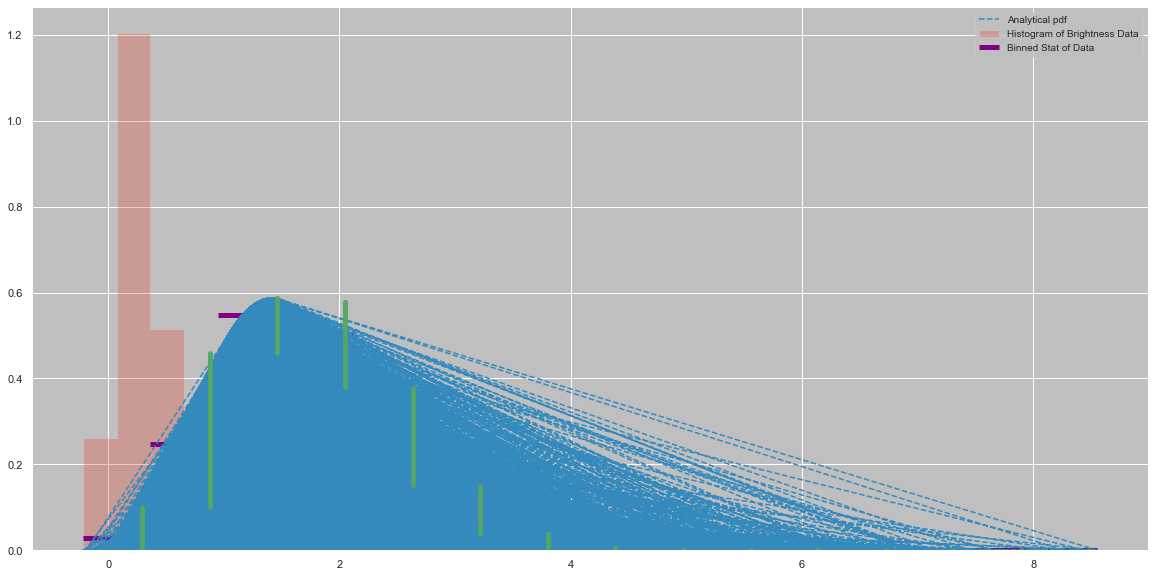

In [79]:
data = pulsar2["Brightness"]
dataPDF = stats.maxwell.pdf(data)
bin_means, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='mean', bins=15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, '--', label = "Analytical pdf")
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='purple', lw=5, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

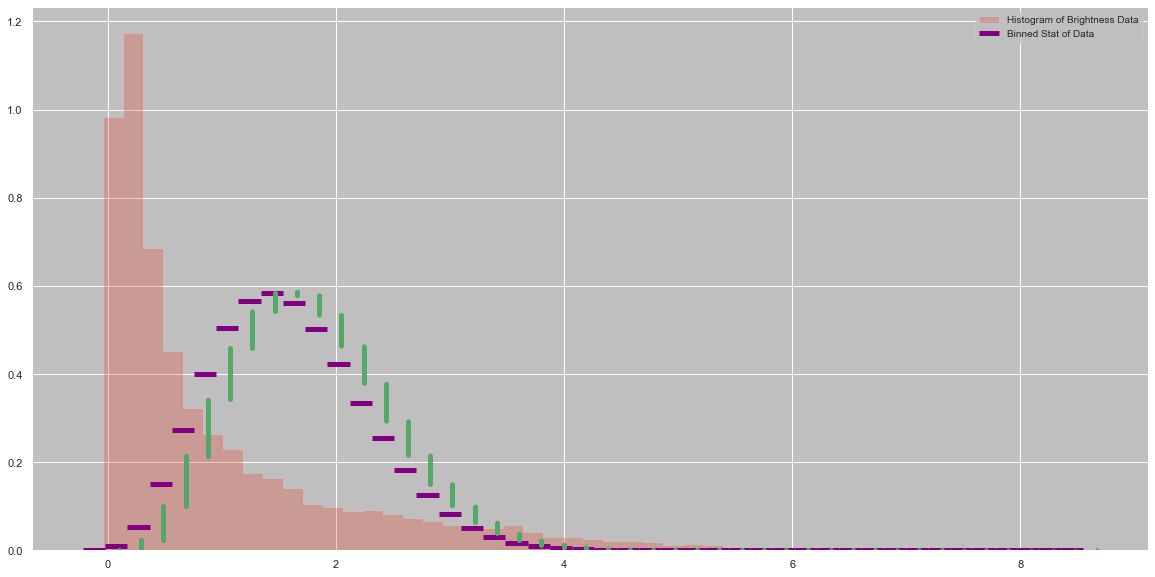

In [80]:
dataPDF = stats.maxwell.pdf(data)
bin_means, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='mean', bins=45)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=50, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='purple', lw=5, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

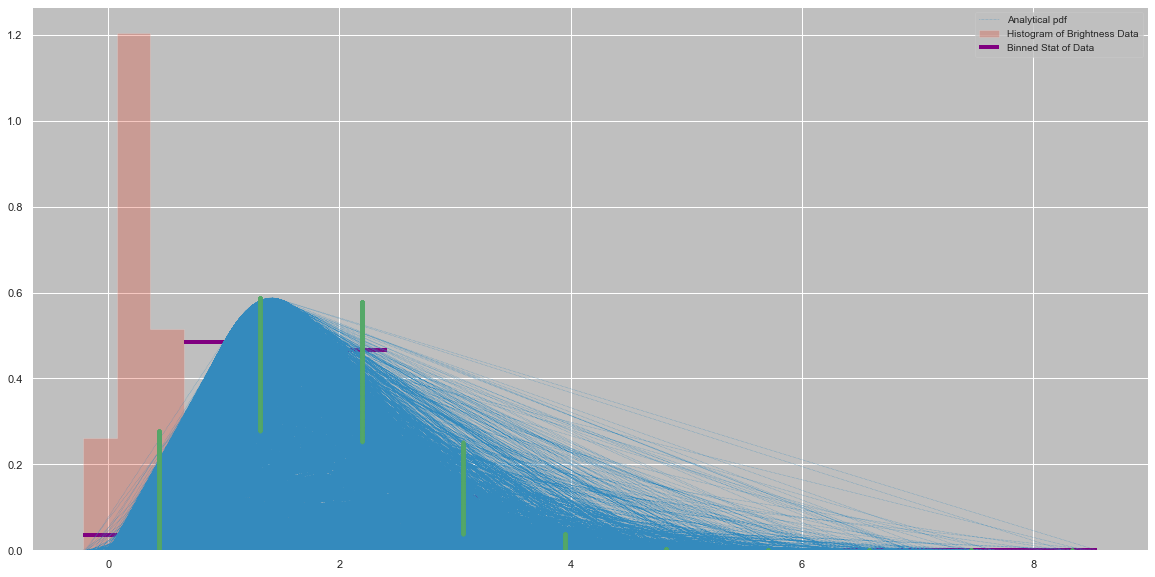

In [81]:
bin_median, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='median', bins=10)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, ':', label = "Analytical pdf", lw=0.5)
plt.hlines(bin_median, bin_edges[:-1], bin_edges[1:], colors='purple', lw=4, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

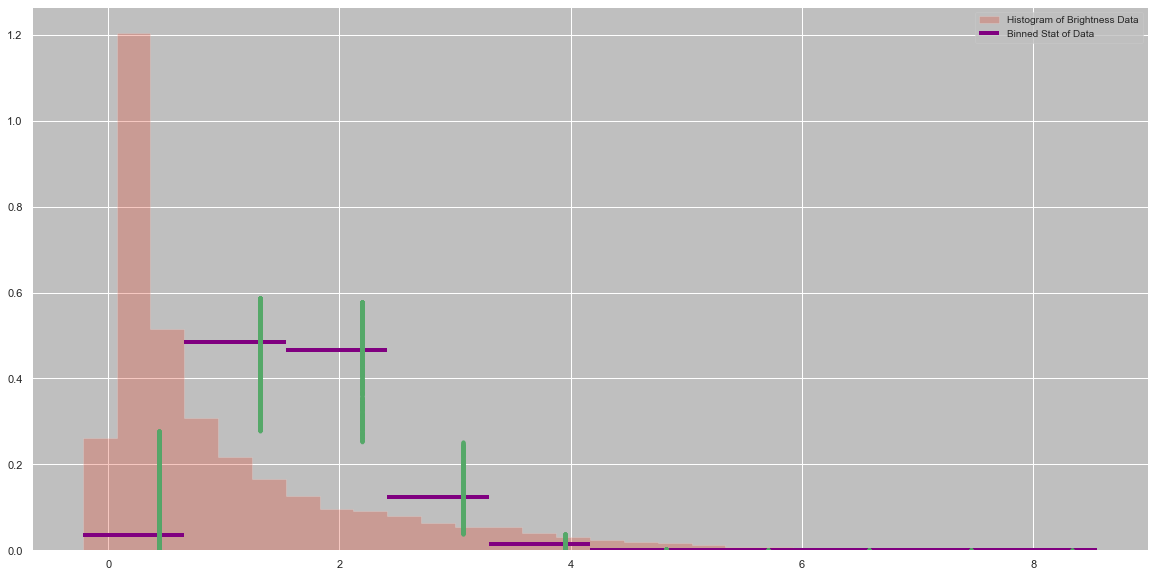

In [82]:
bin_median, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='median', bins=10)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.hlines(bin_median, bin_edges[:-1], bin_edges[1:], colors='purple', lw=4, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

Here we begin to add in the moving averages for further potential data work

In [83]:
pulsar2['RollingMeanEmissions5ths'] = pulsar2["Brightness"].rolling(5).mean()
pulsar2['RollingMeanEmissions10ths'] = pulsar2["Brightness"].rolling(10).mean()
pulsar2['RollingMedianEmissions5ths'] = pulsar2["Brightness"].rolling(5).median()
pulsar2.head(15)

Pulse Number  Brightness  Uncertainty  Binary  RollingMeanEmissions5ths  \
0              1    0.334330     0.015570       0                       NaN   
1              2   -0.098659     0.014051       0                       NaN   
2              3    0.123514     0.011901       0                       NaN   
3              4    0.443923     0.014365       0                       NaN   
4              5    1.590446     0.057785       1                  0.478711   
5              6    1.233848     0.018692       1                  0.658614   
6              7    0.857876     0.022208       1                  0.849921   
7              8    0.254255     0.018185       0                  0.876070   
8              9    0.292077     0.021672       0                  0.845700   
9             10    0.439929     0.046293       0                  0.615597   
10            11    0.824310     0.036243       1                  0.533689   
11            12    1.443460     0.088372       1                  0.650806   
12            13    0.127981     0.018070       0                  0.625551   
13            14    0.327896     0.012362       0                  0.632715   
14            15    2.473663     0.099205       1                  1.039462   

    RollingMeanEmissions10ths  RollingMedianEmissions5ths  
0                         NaN                         NaN  
1                         NaN                         NaN  
2                         NaN                         NaN  
3                         NaN                         NaN  
4                         NaN                    0.334330  
5                         NaN                    0.443923  
6                         NaN                    0.857876  
7                         NaN                    0.857876  
8                         NaN                    0.857876  
9                    0.547154                    0.439929  
10                   0.596152                    0.439929  
11                   0.750364                    0.439929  
12                   0.750810                    0.439929  
13                   0.739208                    0.439929  
14                   0.827529                    0.824310

#### Pulsar 3 (J0835-4510):

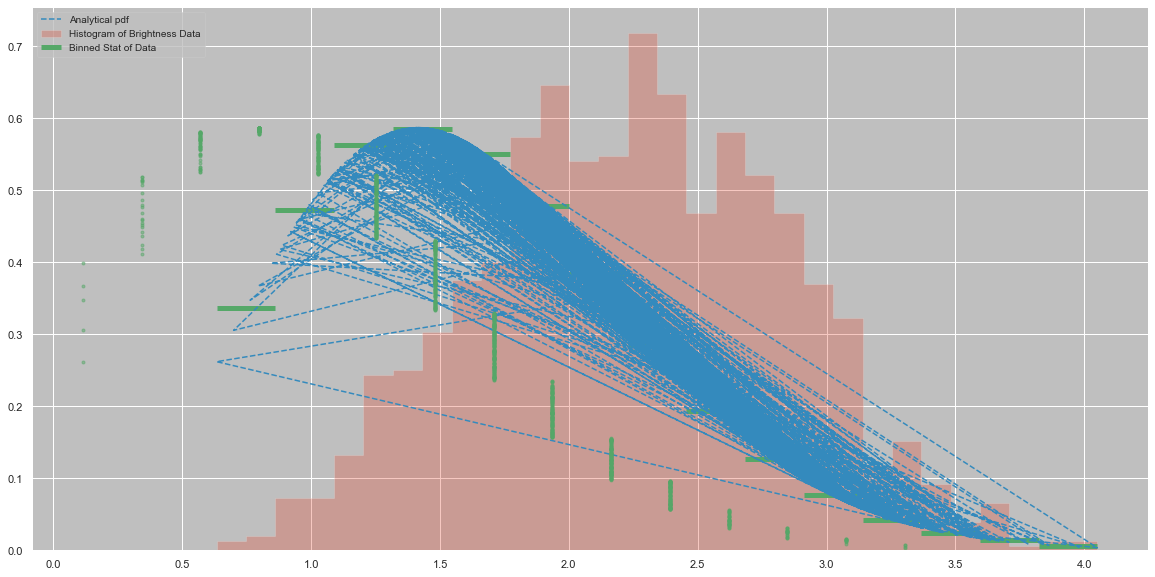

In [84]:
data = pulsar3["Brightness"]
dataPDF = stats.maxwell.pdf(data)
bin_means, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='mean', bins=15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, '--', label = "Analytical pdf")
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], 'g', lw=5, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

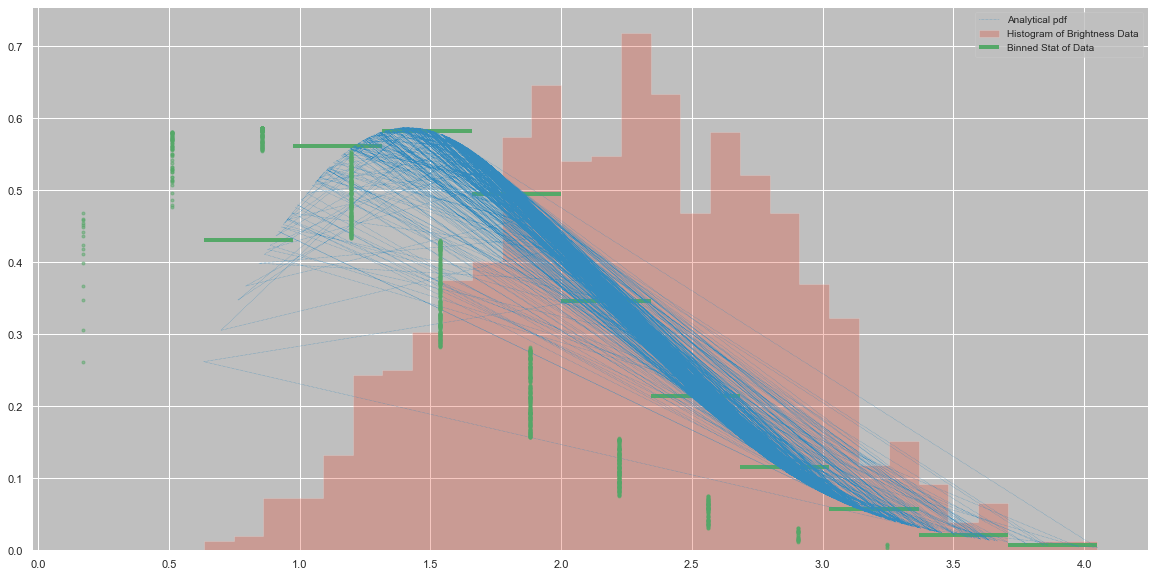

In [85]:
bin_median, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='median', bins=10)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, ':', label = "Analytical pdf", lw=0.5)
plt.hlines(bin_median, bin_edges[:-1], bin_edges[1:], 'g', lw=4, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

Here we begin to add in the moving averages for further potential data work

In [86]:
pulsar3['RollingMeanEmissions5ths'] = pulsar3["Brightness"].rolling(5).mean()
pulsar3['RollingMedianEmissions5ths'] = pulsar3["Brightness"].rolling(5).median()
pulsar3['RollingMedianEmissions10ths'] = pulsar3["Brightness"].rolling(10).median()
pulsar3.head(15)

Pulse Number  Brightness  Uncertainty  Binary  RollingMeanEmissions5ths  \
0              1    0.984043     0.053831       0                       NaN   
1              2    2.487928     0.048796       1                       NaN   
2              3    1.690295     0.025639       0                       NaN   
3              4    1.196142     0.039539       0                       NaN   
4              5    1.979783     0.041460       0                  1.667638   
5              6    2.297645     0.054210       1                  1.930359   
6              7    2.322135     0.043554       1                  1.897200   
7              8    2.289047     0.049957       1                  2.016950   
8              9    2.442574     0.025110       1                  2.266237   
9             10    2.136332     0.022712       0                  2.297547   
10            11    1.976790     0.037551       0                  2.233376   
11            12    2.445764     0.047004       1                  2.258101   
12            13    1.937017     0.028561       0                  2.187695   
13            14    2.315184     0.045216       1                  2.162217   
14            15    2.584888     0.040232       1                  2.251929   

    RollingMedianEmissions5ths  RollingMedianEmissions10ths  
0                          NaN                          NaN  
1                          NaN                          NaN  
2                          NaN                          NaN  
3                          NaN                          NaN  
4                     1.690295                          NaN  
5                     1.979783                          NaN  
6                     1.979783                          NaN  
7                     2.289047                          NaN  
8                     2.297645                          NaN  
9                     2.297645                     2.212689  
10                    2.289047                     2.212689  
11                    2.289047                     2.212689  
12                    2.136332                     2.212689  
13                    2.136332                     2.293346  
14                    2.315184                     2.306414

#### Pulsar 4 (J1243-6423):

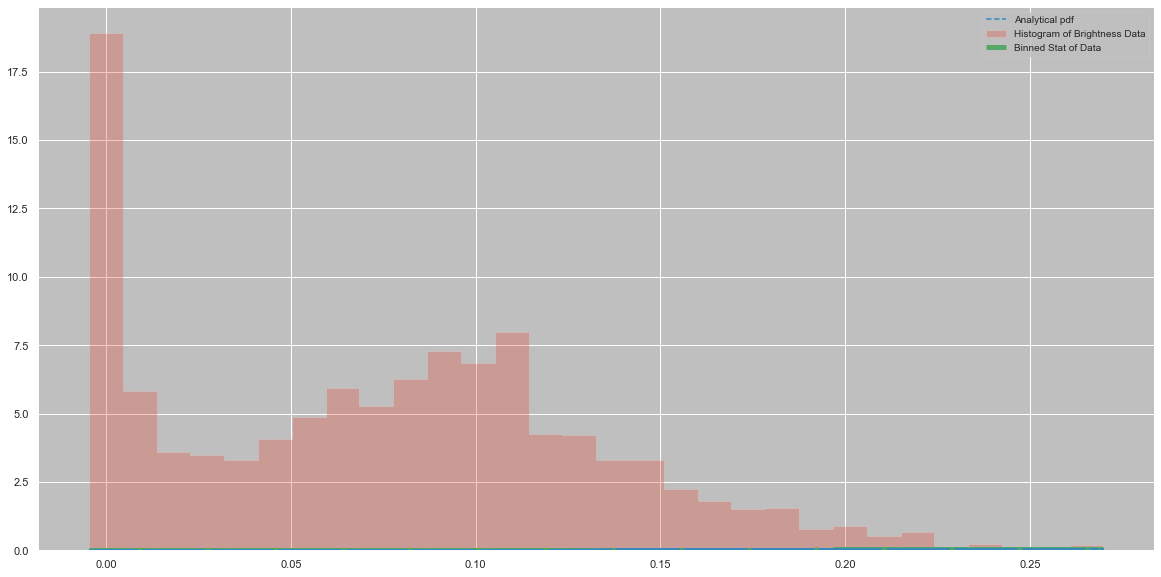

In [87]:
data = pulsar4["Brightness"]
dataPDF = stats.maxwell.pdf(data)
bin_means, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='mean', bins=15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, '--', label = "Analytical pdf")
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], 'g', lw=5, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

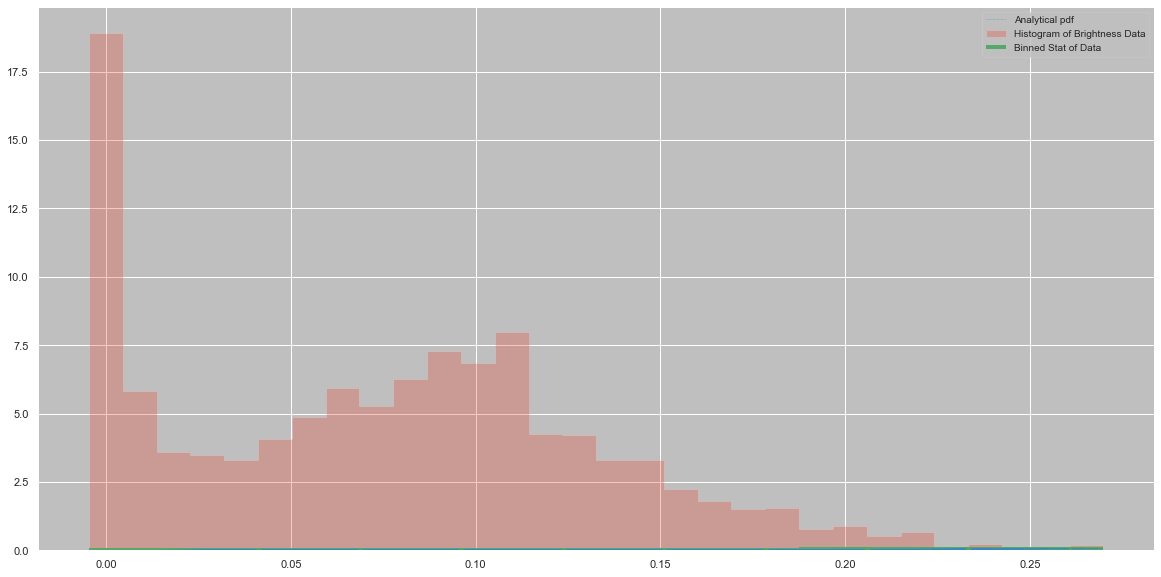

In [88]:
bin_median, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='median', bins=10)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, ':', label = "Analytical pdf", lw=0.5)
plt.hlines(bin_median, bin_edges[:-1], bin_edges[1:], 'g', lw=4, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

Here we begin to add in the moving averages for further potential data work

In [89]:
pulsar4['RollingMeanEmissions5ths'] = pulsar4["Brightness"].rolling(5).mean()
pulsar4['RollingMeanEmissions10ths'] = pulsar4["Brightness"].rolling(10).mean()
pulsar4['RollingMedianEmissions5ths'] = pulsar4["Brightness"].rolling(5).median()
pulsar4['RollingMedianEmissions10ths'] = pulsar4["Brightness"].rolling(10).median()
pulsar4.head(15)

Pulse Number  Brightness  Uncertainty  Binary  RollingMeanEmissions5ths  \
0              1    0.101127     0.001893       1                       NaN   
1              2    0.012166     0.001814       0                       NaN   
2              3    0.021918     0.001835       0                       NaN   
3              4    0.181179     0.002183       1                       NaN   
4              5    0.000240     0.001725       0                  0.063326   
5              6    0.085866     0.001723       1                  0.060274   
6              7    0.067280     0.001778       0                  0.071297   
7              8    0.092884     0.002438       1                  0.085490   
8              9    0.083350     0.002101       1                  0.065924   
9             10    0.087871     0.001941       1                  0.083450   
10            11    0.123529     0.002026       1                  0.090983   
11            12    0.097413     0.001878       1                  0.097009   
12            13    0.100649     0.001820       1                  0.098562   
13            14    0.058025     0.001724       0                  0.093498   
14            15    0.116164     0.001948       1                  0.099156   

    RollingMeanEmissions10ths  RollingMedianEmissions5ths  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                    0.021918   
5                         NaN                    0.021918   
6                         NaN                    0.067280   
7                         NaN                    0.085866   
8                         NaN                    0.083350   
9                    0.073388                    0.085866   
10                   0.075628                    0.087871   
11                   0.084153                    0.092884   
12                   0.092026                    0.097413   
13                   0.079711                    0.097413   
14                   0.091303                    0.100649   

    RollingMedianEmissions10ths  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
5                           NaN  
6                           NaN  
7                           NaN  
8                           NaN  
9                      0.084608  
10                     0.084608  
11                     0.086868  
12                     0.090377  
13                     0.086868  
14                     0.090377


#### Pulsar 5 (J1456-6843):

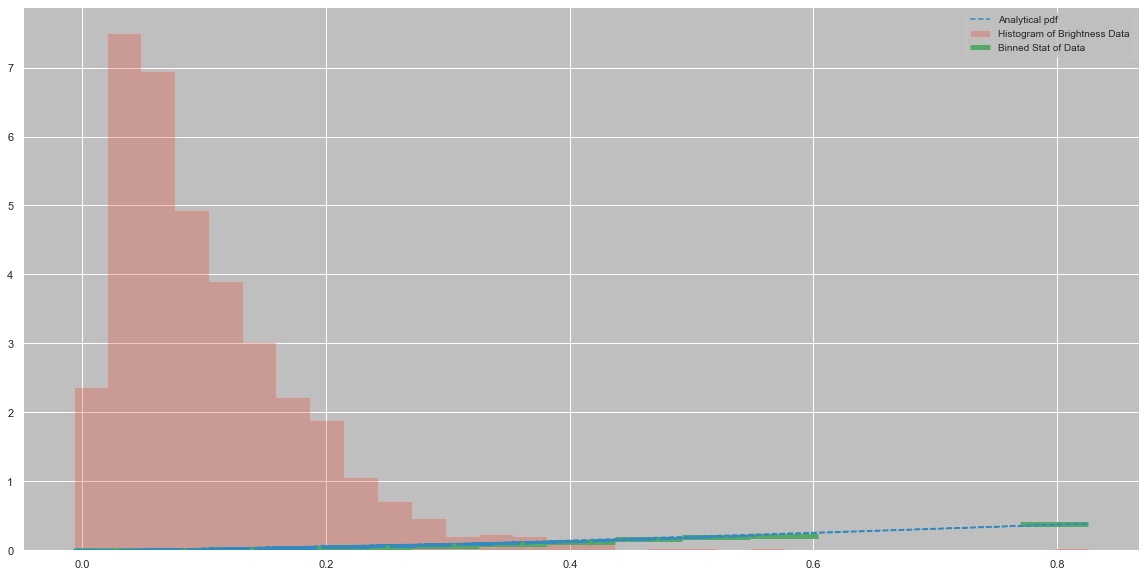

In [90]:
data = pulsar5["Brightness"]
dataPDF = stats.maxwell.pdf(data)
bin_means, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='mean', bins=15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, '--', label = "Analytical pdf")
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], 'g', lw=5, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

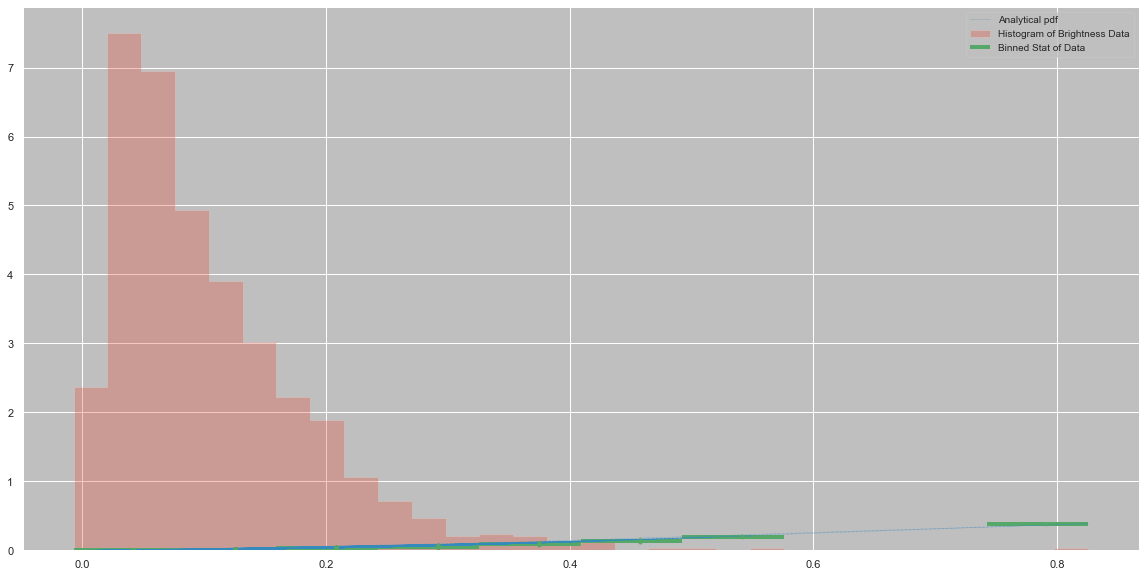

In [91]:
bin_median, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='median', bins=10)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure(figsize=(20,10))
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, ':', label = "Analytical pdf", lw=0.5)
plt.hlines(bin_median, bin_edges[:-1], bin_edges[1:], 'g', lw=4, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

Here we begin to add in the moving averages for further potential data work

In [92]:
pulsar5['RollingMeanEmissions5ths'] = pulsar5["Brightness"].rolling(5).mean()
pulsar5['RollingMeanEmissions10ths'] = pulsar5["Brightness"].rolling(10).mean()
pulsar5['RollingMedianEmissions5ths'] = pulsar5["Brightness"].rolling(5).median()
pulsar5['RollingMedianEmissions10ths'] = pulsar5["Brightness"].rolling(10).median()
pulsar5.head(15)

Pulse Number  Brightness  Uncertainty  Binary  RollingMeanEmissions5ths  \
0              1    0.053904     0.005560       0                       NaN   
1              2    0.058653     0.004821       0                       NaN   
2              3    0.110208     0.005196       1                       NaN   
3              4    0.034716     0.004729       0                       NaN   
4              5    0.056101     0.004619       0                  0.062716   
5              6    0.046168     0.005074       0                  0.061169   
6              7    0.055648     0.004916       0                  0.060568   
7              8    0.060890     0.004581       0                  0.050705   
8              9    0.024388     0.004922       0                  0.048639   
9             10    0.039370     0.004633       0                  0.045293   
10            11    0.009141     0.004581       0                  0.037888   
11            12    0.145273     0.005053       1                  0.055813   
12            13    0.039953     0.004938       0                  0.051625   
13            14   -0.002554     0.004409       0                  0.046237   
14            15    0.035696     0.004903       0                  0.045502   

    RollingMeanEmissions10ths  RollingMedianEmissions5ths  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                    0.056101   
5                         NaN                    0.056101   
6                         NaN                    0.055648   
7                         NaN                    0.055648   
8                         NaN                    0.055648   
9                    0.054005                    0.046168   
10                   0.049528                    0.039370   
11                   0.058190                    0.039370   
12                   0.051165                    0.039370   
13                   0.047438                    0.039370   
14                   0.045397                    0.035696   

    RollingMedianEmissions10ths  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
5                           NaN  
6                           NaN  
7                           NaN  
8                           NaN  
9                      0.054776  
10                     0.050908  
11                     0.050908  
12                     0.043061  
13                     0.043061  
14                     0.039662

#### Pulsar 6 (J1644-4559):

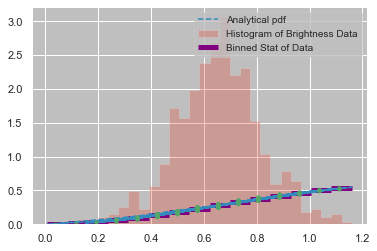

In [93]:
data = pulsar6["Brightness"]
dataPDF = stats.maxwell.pdf(data)
bin_means, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='mean', bins=15)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure()
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, '--', label = "Analytical pdf")
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='purple', lw=5, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

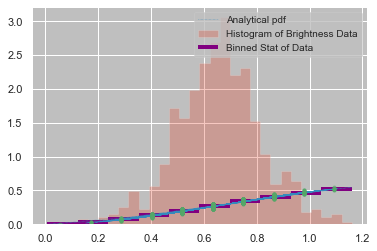

In [94]:
bin_median, bin_edges, binnumber = stats.binned_statistic(data, dataPDF,
        statistic='median', bins=10)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure()
plt.hist(data, bins=30, density=True, histtype='stepfilled', alpha=0.3, label='Histogram of Brightness Data')
plt.plot(data, dataPDF, ':', label = "Analytical pdf", lw=0.5)
plt.hlines(bin_median, bin_edges[:-1], bin_edges[1:], colors='purple', lw=4, label='Binned Stat of Data')
plt.plot((binnumber - 0.5) * bin_width, dataPDF, 'g.', alpha=0.5)
plt.legend(fontsize=10)
plt.show()

Here we begin to add in the moving averages for further potential data work

In [95]:
pulsar6['RollingMeanEmissions5ths'] = pulsar6["Brightness"].rolling(5).mean()
pulsar6['RollingMeanEmissions10ths'] = pulsar6["Brightness"].rolling(10).mean()
pulsar6['RollingMedianEmissions5ths'] = pulsar6["Brightness"].rolling(5).median()
pulsar6['RollingMedianEmissions10ths'] = pulsar6["Brightness"].rolling(10).median()
pulsar6.head(15)

Pulse Number  Brightness  Uncertainty  Binary  RollingMeanEmissions5ths  \
0              1    0.634671     0.002761       0                       NaN   
1              2    0.736945     0.005207       1                       NaN   
2              3    0.693834     0.002706       1                       NaN   
3              4    1.021866     0.010184       1                       NaN   
4              5    0.673845     0.006236       1                  0.752232   
5              6    0.676883     0.004763       1                  0.760675   
6              7    0.527039     0.002422       0                  0.718693   
7              8    0.673417     0.003174       1                  0.714610   
8              9    0.357076     0.002848       0                  0.581652   
9             10    0.661704     0.005588       1                  0.579224   
10            11    0.545564     0.003835       0                  0.552960   
11            12    0.494655     0.003145       0                  0.546483   
12            13    0.804260     0.005258       1                  0.572651   
13            14    0.513362     0.005700       0                  0.603909   
14            15    0.477025     0.002945       0                  0.566973   

    RollingMeanEmissions10ths  RollingMedianEmissions5ths  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                    0.693834   
5                         NaN                    0.693834   
6                         NaN                    0.676883   
7                         NaN                    0.673845   
8                         NaN                    0.673417   
9                    0.665728                    0.661704   
10                   0.656817                    0.545564   
11                   0.632588                    0.545564   
12                   0.643631                    0.545564   
13                   0.592780                    0.545564   
14                   0.573098                    0.513362   

    RollingMedianEmissions10ths  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
5                           NaN  
6                           NaN  
7                           NaN  
8                           NaN  
9                      0.673631  
10                     0.673631  
11                     0.667561  
12                     0.667561  
13                     0.603634  
14                     0.536301

### Machine Learning Both Logistic then Bi-Directional LSTM

#### Pulsar 1 (J0437-4715):

Logistic Regression (Classification Model)

In [96]:
X = pulsar1[['Brightness', 'Uncertainty']]
y = pulsar1['Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)

train_scaler = StandardScaler()
X_train = train_scaler.fit_transform(X_train)

test_scaler = StandardScaler()
X_test = test_scaler.fit_transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [97]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  2716
False Positive(FP) =  45
True Negative(TN)  =  2639
False Negative(FN) =  0


In [98]:
score=model.score(X_test,y_test)
print(score)

0.9916666666666667


Bi-Directional LSTM (Regression Model)

In [99]:
values_list = pulsar1[['Brightness', 'Uncertainty']].values.tolist()
values_list = preprocessing.normalize(values_list)
def split_list(blist, steps):
    X, y = list(), list()
    for i in range(len(blist)):        
        end_ix = i + steps
        if end_ix > len(blist)-1:
            break    
        list_x, list_y = blist[i:end_ix], blist[end_ix][0]
        X.append(list_x)
        y.append(list_y)
    return array(X), array(y)
# splitting the list
X, y = split_list(values_list, 100)
# reshaping the list to feed the model
X = X.reshape((X.shape[0], X.shape[1], 2))
# splitting the list into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
# setting the parameters for the lstm model and compiling it
model = Sequential()
model.add(Bidirectional(LSTM(50), input_shape=(100, 2)))
model.add(Dense(25))
model.add(Dense(12))
model.add(Dense(6))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
# training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=1, batch_size=(int(X_train.shape[0]/50)))
# predicting the y/brightness values for the test set
y_pred = model.predict(X_test, verbose=0)

Epoch 1/5
51/51 [==============================] - 15s 258ms/step - loss: 0.0606 - mse: 0.0606 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/5
51/51 [==============================] - 13s 263ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 3/5
51/51 [==============================] - 14s 277ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 4/5
51/51 [==============================] - 14s 283ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 5/5
51/51 [==============================] - 15s 295ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0034 - val_mse: 0.0034


In [100]:
print('R2 Score: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RSE: ', math.sqrt(mean_absolute_error(y_test, y_pred)))

R2 Score:  0.05848320013973063
MAE:  0.014415606644854041
RSE:  0.12006501007726623


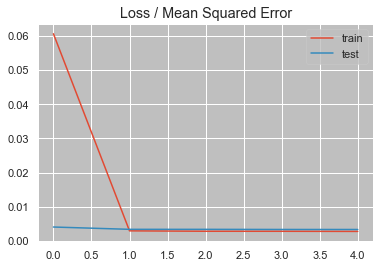

In [101]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### Evaluation

Logistic Regression

Rewards no significant results for this type of analysis and is dropped for a LSTM attempt

Bidirectional LSTM

Loss is low so the model is performing well. But the accuracy is low therefore unable to obtain trend and therefore not rewarding any information. This means we cannot predict any of the values with confidence.

#### Pulsar 2 (J0953+0755):

Logistic Regression (Classification Model)

In [102]:
X = pulsar2[['Brightness', 'Uncertainty']]
y = pulsar2['Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)

train_scaler = StandardScaler()
X_train = train_scaler.fit_transform(X_train)

test_scaler = StandardScaler()
X_test = test_scaler.fit_transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [103]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

score=model.score(X_test,y_test)

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print(score)

True Positive(TP)  =  1394
False Positive(FP) =  1
True Negative(TN)  =  1449
False Negative(FN) =  22
0.9919748778785764


Bi-Directional LSTM (Regression Model)

In [104]:
values_list = pulsar2[['Brightness', 'Uncertainty']].values.tolist()
values_list = preprocessing.normalize(values_list)
def split_list(blist, steps):
    X, y = list(), list()
    for i in range(len(blist)):        
        end_ix = i + steps
        if end_ix > len(blist)-1:
            break    
        list_x, list_y = blist[i:end_ix], blist[end_ix][0]
        X.append(list_x)
        y.append(list_y)
    return array(X), array(y)
# splitting the list
X, y = split_list(values_list, 100)
# reshaping the list to feed the model
X = X.reshape((X.shape[0], X.shape[1], 2))
# splitting the list into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
# setting the parameters for the lstm model and compiling it
model = Sequential()
model.add(Bidirectional(LSTM(50), input_shape=(100, 2)))
model.add(Dense(25))
model.add(Dense(12))
model.add(Dense(6))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
# training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=1, batch_size=(int(X_train.shape[0]/50)))
# predicting the y/brightness values for the test set
y_pred = model.predict(X_test, verbose=0)

Epoch 1/5
51/51 [==============================] - 8s 117ms/step - loss: 0.1242 - mse: 0.1242 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 2/5
51/51 [==============================] - 5s 106ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 3/5
51/51 [==============================] - 6s 128ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 4/5
51/51 [==============================] - 7s 129ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 5/5
51/51 [==============================] - 7s 131ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0175 - val_mse: 0.0175


In [105]:
print('R2 Score: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RSE: ', math.sqrt(mean_absolute_error(y_test, y_pred)))

R2 Score:  -0.008593979702192556
MAE:  0.02869650111569234
RSE:  0.1694004165156991


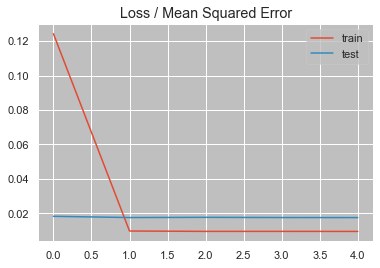

In [106]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### Evaluation

Logistic Regression

Rewards no significant results for this type of analysis and is dropped for a LSTM attempt

Bidirectional LSTM

Loss is low so the model is performing well. But the accuracy is low therefore unable to obtain trend and therefore not rewarding any information. This means we cannot predict any of the values with confidence.

#### Pulsar 3 (J0835-4510):

Logistic Regression (Classification Model)

In [107]:
X = pulsar3[['Brightness', 'Uncertainty']]
y = pulsar3['Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)

train_scaler = StandardScaler()
X_train = train_scaler.fit_transform(X_train)

test_scaler = StandardScaler()
X_test = test_scaler.fit_transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [108]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

score=model.score(X_test,y_test)

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print(score)

True Positive(TP)  =  121
False Positive(FP) =  7
True Negative(TN)  =  139
False Negative(FN) =  0
0.9737827715355806


Bi-Directional LSTM (Regression Model)

In [109]:
values_list = pulsar3[['Brightness', 'Uncertainty']].values.tolist()
values_list = preprocessing.normalize(values_list)
def split_list(blist, steps):
    X, y = list(), list()
    for i in range(len(blist)):        
        end_ix = i + steps
        if end_ix > len(blist)-1:
            break    
        list_x, list_y = blist[i:end_ix], blist[end_ix][0]
        X.append(list_x)
        y.append(list_y)
    return array(X), array(y)
# splitting the list
X, y = split_list(values_list, 100)
# reshaping the list to feed the model
X = X.reshape((X.shape[0], X.shape[1], 2))
# splitting the list into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
# setting the parameters for the lstm model and compiling it
model = Sequential()
model.add(Bidirectional(LSTM(50), input_shape=(100, 2)))
model.add(Dense(25))
model.add(Dense(12))
model.add(Dense(6))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
# training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=1, batch_size=(int(X_train.shape[0]/50)))
# predicting the y/brightness values for the test set
y_pred = model.predict(X_test, verbose=0)

Epoch 1/5
52/52 [==============================] - 4s 37ms/step - loss: 0.0932 - mse: 0.0932 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 2/5
52/52 [==============================] - 1s 26ms/step - loss: 1.6445e-04 - mse: 1.6445e-04 - val_loss: 2.0977e-07 - val_mse: 2.0977e-07
Epoch 3/5
52/52 [==============================] - 1s 26ms/step - loss: 8.9532e-07 - mse: 8.9532e-07 - val_loss: 1.8486e-07 - val_mse: 1.8486e-07
Epoch 4/5
52/52 [==============================] - 1s 26ms/step - loss: 1.7457e-07 - mse: 1.7457e-07 - val_loss: 1.6213e-07 - val_mse: 1.6213e-07
Epoch 5/5
52/52 [==============================] - 1s 25ms/step - loss: 1.6655e-07 - mse: 1.6655e-07 - val_loss: 1.5735e-07 - val_mse: 1.5735e-07


In [110]:
print('R2 Score: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RSE: ', math.sqrt(mean_absolute_error(y_test, y_pred)))

R2 Score:  -5.232615484563366
MAE:  0.0003007963990194052
RSE:  0.01734348289760177


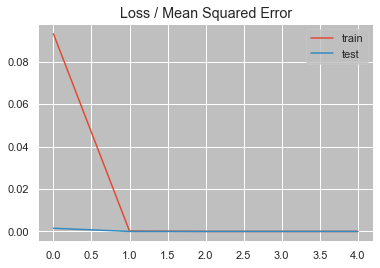

In [111]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### Evaluation

Logistic Regression

Rewards no significant results for this type of analysis and is dropped for a LSTM attempt

Bidirectional LSTM

Loss is low so the model is performing well. But the accuracy is low therefore unable to obtain trend and therefore not rewarding any information. This means we cannot predict any of the values with confidence.

#### Pulsar 4 (J1243-6423):

Logistic Regression (Classification Model)

In [112]:
X = pulsar4[['Brightness', 'Uncertainty']]
y = pulsar4['Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)

train_scaler = StandardScaler()
X_train = train_scaler.fit_transform(X_train)

test_scaler = StandardScaler()
X_test = test_scaler.fit_transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [113]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

score=model.score(X_test,y_test)

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print(score)

True Positive(TP)  =  165
False Positive(FP) =  7
True Negative(TN)  =  192
False Negative(FN) =  0
0.9807692307692307


Bi-Directional LSTM (Regression Model)

In [114]:
values_list = pulsar4[['Brightness', 'Uncertainty']].values.tolist()
values_list = preprocessing.normalize(values_list)
def split_list(blist, steps):
    X, y = list(), list()
    for i in range(len(blist)):        
        end_ix = i + steps
        if end_ix > len(blist)-1:
            break    
        list_x, list_y = blist[i:end_ix], blist[end_ix][0]
        X.append(list_x)
        y.append(list_y)
    return array(X), array(y)
# splitting the list
X, y = split_list(values_list, 100)
# reshaping the list to feed the model
X = X.reshape((X.shape[0], X.shape[1], 2))
# splitting the list into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
# setting the parameters for the lstm model and compiling it
model = Sequential()
model.add(Bidirectional(LSTM(50), input_shape=(100, 2)))
model.add(Dense(25))
model.add(Dense(12))
model.add(Dense(6))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
# training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=1, batch_size=(int(X_train.shape[0]/50)))
# predicting the y/brightness values for the test set
y_pred = model.predict(X_test, verbose=0)

Epoch 1/5
51/51 [==============================] - 4s 37ms/step - loss: 0.1486 - mse: 0.1486 - val_loss: 0.1051 - val_mse: 0.1051
Epoch 2/5
51/51 [==============================] - 1s 26ms/step - loss: 0.0920 - mse: 0.0920 - val_loss: 0.1006 - val_mse: 0.1006
Epoch 3/5
51/51 [==============================] - 1s 26ms/step - loss: 0.0922 - mse: 0.0922 - val_loss: 0.1014 - val_mse: 0.1014
Epoch 4/5
51/51 [==============================] - 1s 25ms/step - loss: 0.0930 - mse: 0.0930 - val_loss: 0.1087 - val_mse: 0.1087
Epoch 5/5
51/51 [==============================] - 1s 28ms/step - loss: 0.0930 - mse: 0.0930 - val_loss: 0.1016 - val_mse: 0.1016


In [115]:
print('R2 Score: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RSE: ', math.sqrt(mean_absolute_error(y_test, y_pred)))

R2 Score:  0.4683583734968013
MAE:  0.18574819977548918
RSE:  0.4309851502957952


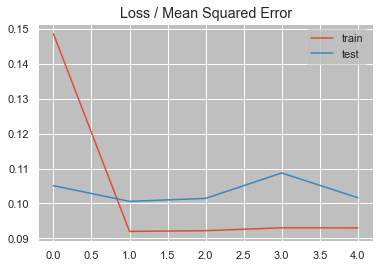

In [116]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### Evaluation

Logistic Regression

Rewards no significant results for this type of analysis and is dropped for a LSTM attempt

Bidirectional LSTM

Loss is low so the model is performing well. But the accuracy is low therefore unable to obtain trend and therefore not rewarding any information. This means we cannot predict any of the values with confidence.

#### Pulsar 5 (J1456-6843):

Logistic Regression (Classification Model)

In [117]:
X = pulsar5[['Brightness', 'Uncertainty']]
y = pulsar5['Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)

train_scaler = StandardScaler()
X_train = train_scaler.fit_transform(X_train)

test_scaler = StandardScaler()
X_test = test_scaler.fit_transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [118]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

score=model.score(X_test,y_test)

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print(score)

True Positive(TP)  =  123
False Positive(FP) =  0
True Negative(TN)  =  110
False Negative(FN) =  11
0.9549180327868853


Bi-Directional LSTM (Regression Model)

In [119]:
values_list = pulsar5[['Brightness', 'Uncertainty']].values.tolist()
values_list = preprocessing.normalize(values_list)
def split_list(blist, steps):
    X, y = list(), list()
    for i in range(len(blist)):        
        end_ix = i + steps
        if end_ix > len(blist)-1:
            break    
        list_x, list_y = blist[i:end_ix], blist[end_ix][0]
        X.append(list_x)
        y.append(list_y)
    return array(X), array(y)
# splitting the list
X, y = split_list(values_list, 100)
# reshaping the list to feed the model
X = X.reshape((X.shape[0], X.shape[1], 2))
# splitting the list into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
# setting the parameters for the lstm model and compiling it
model = Sequential()
model.add(Bidirectional(LSTM(50), input_shape=(100, 2)))
model.add(Dense(25))
model.add(Dense(12))
model.add(Dense(6))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
# training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, verbose=1, batch_size=(int(X_train.shape[0]/50)))
# predicting the y/brightness values for the test set
y_pred = model.predict(X_test, verbose=0)

Epoch 1/2
53/53 [==============================] - 5s 44ms/step - loss: 0.0862 - mse: 0.0862 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 2/2
53/53 [==============================] - 2s 29ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0011 - val_mse: 0.0011


In [120]:
print('R2 Score: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RSE: ', math.sqrt(mean_absolute_error(y_test, y_pred)))

R2 Score:  -6.505993418621036
MAE:  0.02551917383260615
RSE:  0.15974721854419296


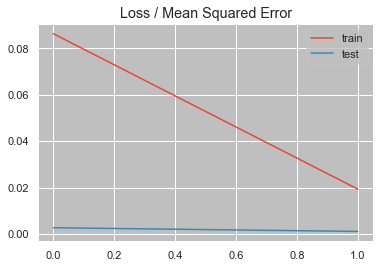

In [121]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### Evaluation

Logistic Regression

Rewards no significant results for this type of analysis and is dropped for a LSTM attempt

Bidirectional LSTM

Loss is low so the model is performing well. But the accuracy is low therefore unable to obtain trend and therefore not rewarding any information. This means we cannot predict any of the values with confidence.


#### Pulsar 6 (J1644-4559):

Logistic Regression (Classification Model)

In [122]:
X = pulsar6[['Brightness', 'Uncertainty']]
y = pulsar6['Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)

train_scaler = StandardScaler()
X_train = train_scaler.fit_transform(X_train)

test_scaler = StandardScaler()
X_test = test_scaler.fit_transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [123]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

score=model.score(X_test,y_test)

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print(score)

True Positive(TP)  =  65
False Positive(FP) =  9
True Negative(TN)  =  66
False Negative(FN) =  0
0.9357142857142857


Bi-Directional LSTM (Regression Model)

In [124]:
values_list = pulsar6[['Brightness', 'Uncertainty']].values.tolist()
values_list = preprocessing.normalize(values_list)
def split_list(blist, steps):
    X, y = list(), list()
    for i in range(len(blist)):        
        end_ix = i + steps
        if end_ix > len(blist)-1:
            break    
        list_x, list_y = blist[i:end_ix], blist[end_ix][0]
        X.append(list_x)
        y.append(list_y)
    return array(X), array(y)
# splitting the list
X, y = split_list(values_list, 100)
# reshaping the list to feed the model
X = X.reshape((X.shape[0], X.shape[1], 2))
# splitting the list into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20)
# setting the parameters for the lstm model and compiling it
model = Sequential()
model.add(Bidirectional(LSTM(50), input_shape=(100, 2)))
model.add(Dense(25))
model.add(Dense(12))
model.add(Dense(6))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
# training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=1, batch_size=(int(X_train.shape[0]/50)))
# predicting the y/brightness values for the test set
y_pred = model.predict(X_test, verbose=0)

Epoch 1/5
54/54 [==============================] - 4s 37ms/step - loss: 0.0851 - mse: 0.0851 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 2/5
54/54 [==============================] - 1s 25ms/step - loss: 1.4379e-04 - mse: 1.4379e-04 - val_loss: 3.2544e-06 - val_mse: 3.2544e-06
Epoch 3/5
54/54 [==============================] - 1s 26ms/step - loss: 6.9280e-07 - mse: 6.9280e-07 - val_loss: 4.0650e-07 - val_mse: 4.0650e-07
Epoch 4/5
54/54 [==============================] - 1s 26ms/step - loss: 2.7915e-07 - mse: 2.7915e-07 - val_loss: 4.2872e-07 - val_mse: 4.2872e-07
Epoch 5/5
54/54 [==============================] - 1s 26ms/step - loss: 2.5502e-07 - mse: 2.5502e-07 - val_loss: 4.4464e-07 - val_mse: 4.4464e-07


In [125]:
print('R2 Score: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RSE: ', math.sqrt(mean_absolute_error(y_test, y_pred)))

R2 Score:  -810.5787647885551
MAE:  0.0003299506848209353
RSE:  0.01816454471823985


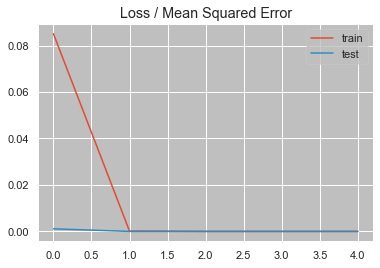

In [126]:
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### Evaluation

Logistic Regression

Rewards no significant results for this type of analysis and is dropped for a LSTM attempt

Bidirectional LSTM

Loss is low so the model is performing well. But the accuracy is low therefore unable to obtain trend and therefore not rewarding any information. This means we cannot predict any of the values with confidence.

### Auto Correlation and Covariance with Export of pulsar with correlated dataset.

#### Pulsar 1 (J0437-4715):

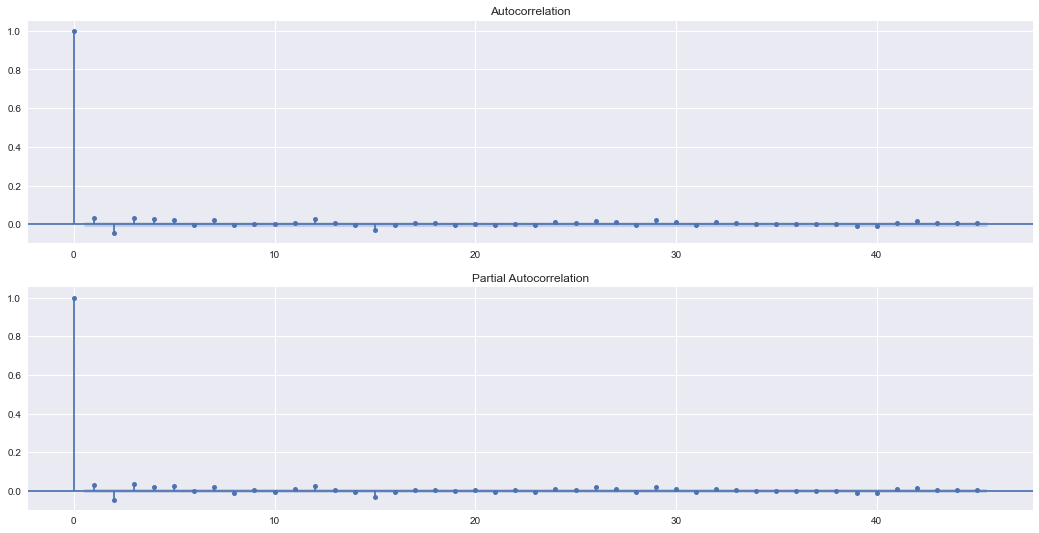

In [127]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (18, 9)

fig, ax = plt.subplots(2,1)

acf = plot_acf(pulsar1['Brightness'], ax=ax[0])
pacf = plot_pacf(pulsar1['Brightness'], ax=ax[1], method="ols")

In [128]:
acfpulsar = pd.DataFrame()
for lag in range(0,11):
    acfpulsar[f"B_lag_{lag}"] = pulsar1['Brightness'].shift(lag)

acfpulsar

B_lag_0   B_lag_1   B_lag_2   B_lag_3   B_lag_4   B_lag_5   B_lag_6  \
0      0.598393       NaN       NaN       NaN       NaN       NaN       NaN   
1      0.590859  0.598393       NaN       NaN       NaN       NaN       NaN   
2      0.449643  0.590859  0.598393       NaN       NaN       NaN       NaN   
3      0.682860  0.449643  0.590859  0.598393       NaN       NaN       NaN   
4      0.490026  0.682860  0.449643  0.590859  0.598393       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
26995  0.539079  0.396929  1.014446  0.659313  1.173766  0.606806  0.500412   
26996  0.324070  0.539079  0.396929  1.014446  0.659313  1.173766  0.606806   
26997  0.291341  0.324070  0.539079  0.396929  1.014446  0.659313  1.173766   
26998  0.346267  0.291341  0.324070  0.539079  0.396929  1.014446  0.659313   
26999  0.513315  0.346267  0.291341  0.324070  0.539079  0.396929  1.014446   

        B_lag_7   B_lag_8   B_lag_9  B_lag_10  
0           NaN       NaN       NaN       NaN  
1           NaN       NaN       NaN       NaN  
2           NaN       NaN       NaN       NaN  
3           NaN       NaN       NaN       NaN  
4           NaN       NaN       NaN       NaN  
...         ...       ...       ...       ...  
26995  0.409631  0.698172  0.262350  0.447577  
26996  0.500412  0.409631  0.698172  0.262350  
26997  0.606806  0.500412  0.409631  0.698172  
26998  1.173766  0.606806  0.500412  0.409631  
26999  0.659313  1.173766  0.606806  0.500412  

[27000 rows x 11 columns]

In [129]:
acfpulsar.corr()["B_lag_0"].values

array([ 1.00000000e+00,  3.02297663e-02, -4.45598682e-02,  3.11938480e-02,
        2.59227920e-02,  2.29443159e-02, -2.72489307e-03,  2.17154085e-02,
       -5.63853223e-03,  1.61145686e-03, -7.10263111e-04])

Based on the auctocorrlation function (ACF) and partial autocorrelation function (PACF) above, we take every 5th observation and create a new dataset that removes some of the autocorrelation present and hopefully provides a data set that is random

In [130]:
held5ths = pulsar1[pulsar1.index % 5 == 0]

Then creating a binary column for this new dataset

In [131]:
np.savetxt(r'every5thbinarypulsar1.txt', held5ths.Binary, fmt='%d', delimiter='')
pulsar15thsbinary = held5ths.Binary.to_list()
np.savetxt(r'allpulsar1.txt', pulsar1.Binary, fmt='%d', delimiter='')

#### Pulsar 2 (J0953+0755):

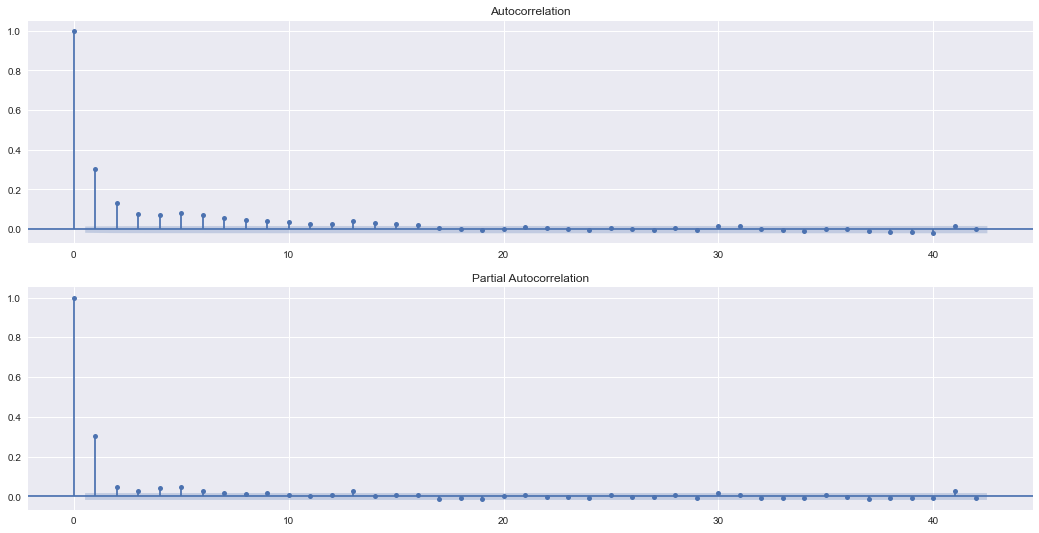

In [132]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (18, 9)

fig, ax = plt.subplots(2,1)

acf = plot_acf(pulsar2['Brightness'], ax=ax[0])
pacf = plot_pacf(pulsar2['Brightness'], ax=ax[1], method="ols")

In [133]:
acfpulsar = pd.DataFrame()
for lag in range(0,11):
    acfpulsar[f"B_lag_{lag}"] = pulsar2['Brightness'].shift(lag)

acfpulsar

B_lag_0   B_lag_1   B_lag_2   B_lag_3   B_lag_4   B_lag_5   B_lag_6  \
0      0.334330       NaN       NaN       NaN       NaN       NaN       NaN   
1     -0.098659  0.334330       NaN       NaN       NaN       NaN       NaN   
2      0.123514 -0.098659  0.334330       NaN       NaN       NaN       NaN   
3      0.443923  0.123514 -0.098659  0.334330       NaN       NaN       NaN   
4      1.590446  0.443923  0.123514 -0.098659  0.334330       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
14324  4.876881  5.386421  3.224787  1.953645  4.624813  0.225158  1.502603   
14325  2.074136  4.876881  5.386421  3.224787  1.953645  4.624813  0.225158   
14326  0.585504  2.074136  4.876881  5.386421  3.224787  1.953645  4.624813   
14327  0.360930  0.585504  2.074136  4.876881  5.386421  3.224787  1.953645   
14328  8.409811  0.360930  0.585504  2.074136  4.876881  5.386421  3.224787   

        B_lag_7   B_lag_8   B_lag_9  B_lag_10  
0           NaN       NaN       NaN       NaN  
1           NaN       NaN       NaN       NaN  
2           NaN       NaN       NaN       NaN  
3           NaN       NaN       NaN       NaN  
4           NaN       NaN       NaN       NaN  
...         ...       ...       ...       ...  
14324  1.389349  1.592995  2.913151  0.181665  
14325  1.502603  1.389349  1.592995  2.913151  
14326  0.225158  1.502603  1.389349  1.592995  
14327  4.624813  0.225158  1.502603  1.389349  
14328  1.953645  4.624813  0.225158  1.502603  

[14329 rows x 11 columns]

In [134]:
acfpulsar.corr()["B_lag_0"].values

array([1.        , 0.30191886, 0.13272532, 0.07726788, 0.07374568,
       0.08110522, 0.07062283, 0.0556971 , 0.04374889, 0.04288793,
       0.0367024 ])

Based on the auctocorrlation function (ACF) and partial autocorrelation function (PACF) above, we take every 5th observation and create a new dataset that removes some of the autocorrelation present and hopefully provides a data set that is random

In [135]:
held5ths = pulsar2[pulsar2.index % 5 == 0]

Then creating a binary column for this new dataset

In [136]:
np.savetxt(r'every5thbinarypulsar2.txt', held5ths.Binary, fmt='%d', delimiter='')
pulsar25thsbinary = held5ths.Binary.to_list()
np.savetxt(r'allpulsar2.txt', pulsar2.Binary, fmt='%d', delimiter='')

#### Pulsar 3 (J0835-4510):

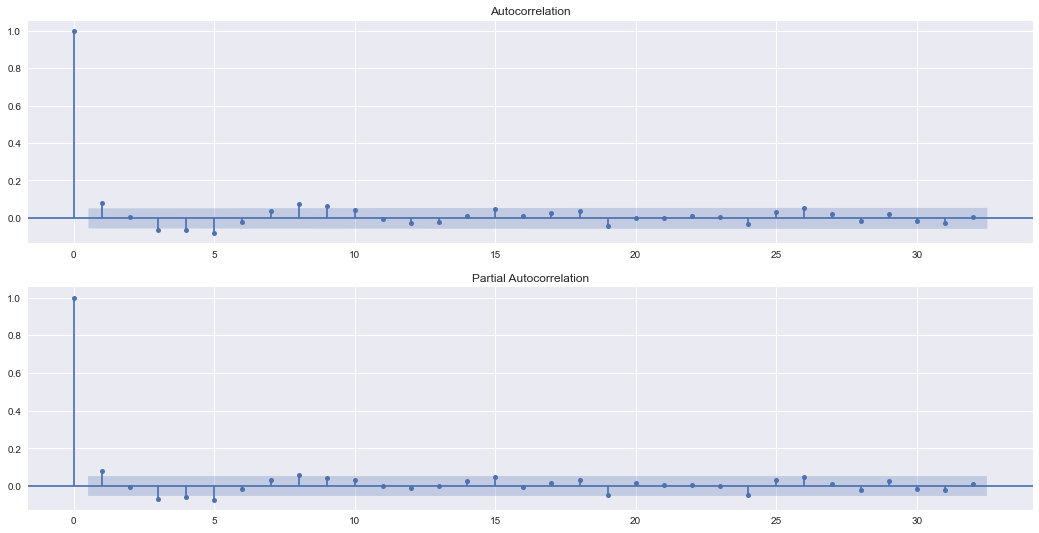

In [137]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (18, 9)

fig, ax = plt.subplots(2,1)

acf = plot_acf(pulsar3['Brightness'], ax=ax[0])
pacf = plot_pacf(pulsar3['Brightness'], ax=ax[1], method="ols")

In [138]:
acfpulsar = pd.DataFrame()
for lag in range(0,11):
    acfpulsar[f"B_lag_{lag}"] = pulsar3['Brightness'].shift(lag)

acfpulsar

B_lag_0   B_lag_1   B_lag_2   B_lag_3   B_lag_4   B_lag_5   B_lag_6  \
0     0.984043       NaN       NaN       NaN       NaN       NaN       NaN   
1     2.487928  0.984043       NaN       NaN       NaN       NaN       NaN   
2     1.690295  2.487928  0.984043       NaN       NaN       NaN       NaN   
3     1.196142  1.690295  2.487928  0.984043       NaN       NaN       NaN   
4     1.979783  1.196142  1.690295  2.487928  0.984043       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
1326  1.842016  2.646750  2.258860  2.123736  2.503202  2.178636  1.392491   
1327  1.547695  1.842016  2.646750  2.258860  2.123736  2.503202  2.178636   
1328  2.797312  1.547695  1.842016  2.646750  2.258860  2.123736  2.503202   
1329  3.351977  2.797312  1.547695  1.842016  2.646750  2.258860  2.123736   
1330  3.115255  3.351977  2.797312  1.547695  1.842016  2.646750  2.258860   

       B_lag_7   B_lag_8   B_lag_9  B_lag_10  
0          NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN  
2          NaN       NaN       NaN       NaN  
3          NaN       NaN       NaN       NaN  
4          NaN       NaN       NaN       NaN  
...        ...       ...       ...       ...  
1326  1.886326  1.810641  1.943447  1.950708  
1327  1.392491  1.886326  1.810641  1.943447  
1328  2.178636  1.392491  1.886326  1.810641  
1329  2.503202  2.178636  1.392491  1.886326  
1330  2.123736  2.503202  2.178636  1.392491  

[1331 rows x 11 columns]

In [139]:
acfpulsar.corr()["B_lag_0"].values

array([ 1.        ,  0.0811623 ,  0.00414645, -0.06751767, -0.06595236,
       -0.08029629, -0.02066581,  0.0379259 ,  0.07664111,  0.06149054,
        0.04473245])

Based on the auctocorrlation function (ACF) and partial autocorrelation function (PACF) above, we take every 5th observation and create a new dataset that removes some of the autocorrelation present and hopefully provides a data set that is random

In [140]:
held5ths = pulsar3[pulsar3.index % 5 == 0]

Then creating a binary column for this new dataset

In [141]:
np.savetxt(r'every5thbinarypulsar3.txt', held5ths.Binary, fmt='%d', delimiter='')
pulsar35thsbinary = held5ths.Binary.to_list()
np.savetxt(r'allpulsar3.txt', pulsar3.Binary, fmt='%d', delimiter='')

#### Pulsar 4 (J1243-6423):

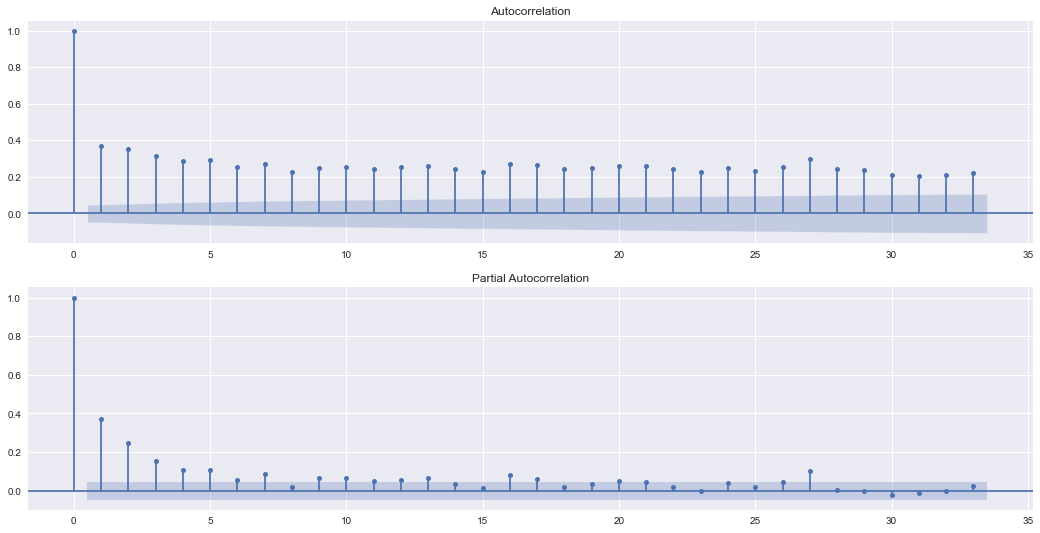

In [142]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (18, 9)

fig, ax = plt.subplots(2,1)

acf = plot_acf(pulsar4['Brightness'], ax=ax[0])
pacf = plot_pacf(pulsar4['Brightness'], ax=ax[1], method="ols")

In [143]:
acfpulsar = pd.DataFrame()
for lag in range(0,11):
    acfpulsar[f"B_lag_{lag}"] = pulsar4['Brightness'].shift(lag)

acfpulsar

B_lag_0   B_lag_1   B_lag_2   B_lag_3   B_lag_4   B_lag_5   B_lag_6  \
0     0.101127       NaN       NaN       NaN       NaN       NaN       NaN   
1     0.012166  0.101127       NaN       NaN       NaN       NaN       NaN   
2     0.021918  0.012166  0.101127       NaN       NaN       NaN       NaN   
3     0.181179  0.021918  0.012166  0.101127       NaN       NaN       NaN   
4     0.000240  0.181179  0.021918  0.012166  0.101127       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
1814  0.105178  0.008539  0.053246  0.024587  0.004085  0.000947  0.044895   
1815  0.064272  0.105178  0.008539  0.053246  0.024587  0.004085  0.000947   
1816  0.000171  0.064272  0.105178  0.008539  0.053246  0.024587  0.004085   
1817 -0.000924  0.000171  0.064272  0.105178  0.008539  0.053246  0.024587   
1818  0.000001 -0.000924  0.000171  0.064272  0.105178  0.008539  0.053246   

       B_lag_7   B_lag_8   B_lag_9  B_lag_10  
0          NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN  
2          NaN       NaN       NaN       NaN  
3          NaN       NaN       NaN       NaN  
4          NaN       NaN       NaN       NaN  
...        ...       ...       ...       ...  
1814  0.007906  0.048652  0.013009  0.006294  
1815  0.044895  0.007906  0.048652  0.013009  
1816  0.000947  0.044895  0.007906  0.048652  
1817  0.004085  0.000947  0.044895  0.007906  
1818  0.024587  0.004085  0.000947  0.044895  

[1819 rows x 11 columns]

In [144]:
acfpulsar.corr()["B_lag_0"].values

array([1.        , 0.37158343, 0.35041747, 0.31258703, 0.28752434,
       0.29153195, 0.25533259, 0.27276504, 0.22759855, 0.2492633 ,
       0.25277541])

The autocorrelation function (ACF) above suggests that their is autocorrelation present for at least 35 lags, giving early evidence that the brightness for this particular pulsar may not be random. Looking at the partial autocorrelation function (PACF) it suggests strong partial autocorrelation exists for about 5 lags, but also shows moderate partial correlation up to  about 10 lags. Hence based off the PACF, 2 more datasets are created for Pulsar 4, one with every 5th observation and one with every 10th observation. 

In [145]:
held5ths = pulsar4[pulsar4.index % 5 == 0]
held10ths = pulsar4[pulsar4.index % 10 == 0]

Then creating a binary column for these new datasets

In [146]:
np.savetxt(r'every5thbinarypulsar4.txt', held5ths.Binary, fmt='%d', delimiter='')
pulsar45thsbinary = held5ths.Binary.to_list()
np.savetxt(r'allpulsar4.txt', pulsar4.Binary, fmt='%d', delimiter='')
np.savetxt(r'every10thbinarypulsar4.txt', held10ths.Binary, fmt='%d', delimiter='')
pulsar410thsbinary = held10ths.Binary.to_list()


#### Pulsar 5 (J1456-6843):

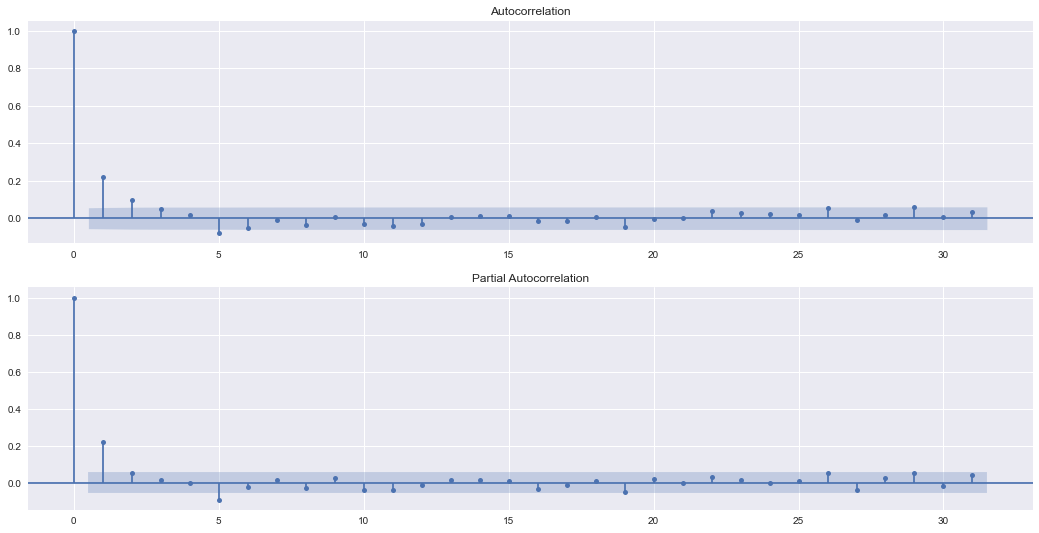

In [147]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (18, 9)

fig, ax = plt.subplots(2,1)

acf = plot_acf(pulsar5['Brightness'], ax=ax[0])
pacf = plot_pacf(pulsar5['Brightness'], ax=ax[1], method="ols")

In [148]:
acfpulsar = pd.DataFrame()
for lag in range(0,11):
    acfpulsar[f"B_lag_{lag}"] = pulsar5['Brightness'].shift(lag)

acfpulsar

B_lag_0   B_lag_1   B_lag_2   B_lag_3   B_lag_4   B_lag_5  \
0     5.390386e-02       NaN       NaN       NaN       NaN       NaN   
1     5.865279e-02  0.053904       NaN       NaN       NaN       NaN   
2     1.102083e-01  0.058653  0.053904       NaN       NaN       NaN   
3     3.471609e-02  0.110208  0.058653  0.053904       NaN       NaN   
4     5.610133e-02  0.034716  0.110208  0.058653  0.053904       NaN   
...            ...       ...       ...       ...       ...       ...   
1214  4.321559e-02  0.031916  0.030713  0.116777  0.144606  0.165039   
1215  1.830750e-02  0.043216  0.031916  0.030713  0.116777  0.144606   
1216  1.155671e-01  0.018308  0.043216  0.031916  0.030713  0.116777   
1217  1.562609e-02  0.115567  0.018308  0.043216  0.031916  0.030713   
1218 -1.137418e-08  0.015626  0.115567  0.018308  0.043216  0.031916   

       B_lag_6   B_lag_7   B_lag_8   B_lag_9  B_lag_10  
0          NaN       NaN       NaN       NaN       NaN  
1          NaN       NaN       NaN       NaN       NaN  
2          NaN       NaN       NaN       NaN       NaN  
3          NaN       NaN       NaN       NaN       NaN  
4          NaN       NaN       NaN       NaN       NaN  
...        ...       ...       ...       ...       ...  
1214  0.148642  0.071752  0.008108  0.038793  0.084002  
1215  0.165039  0.148642  0.071752  0.008108  0.038793  
1216  0.144606  0.165039  0.148642  0.071752  0.008108  
1217  0.116777  0.144606  0.165039  0.148642  0.071752  
1218  0.030713  0.116777  0.144606  0.165039  0.148642  

[1219 rows x 11 columns]

In [149]:
acfpulsar.corr()["B_lag_0"].values

array([ 1.        ,  0.22179701,  0.09954441,  0.04675654,  0.01880625,
       -0.07839106, -0.05409556, -0.01226841, -0.03581717,  0.00521062,
       -0.03030331])

Based on the auctocorrlation function (ACF) and partial autocorrelation function (PACF) above, we take every 5th observation and create a new dataset that removes some of the autocorrelation present and hopefully provides a data set that is random

In [150]:
held5ths = pulsar5[pulsar5.index % 5 == 0]

Then creating a binary column for this new dataset

In [151]:
np.savetxt(r'every5thbinarypulsar5.txt', held5ths.Binary, fmt='%d', delimiter='')
pulsar55thsbinary = held5ths.Binary.to_list()
np.savetxt(r'allpulsar5.txt', pulsar5.Binary, fmt='%d', delimiter='')


#### Pulsar 6 (J1644-4559):

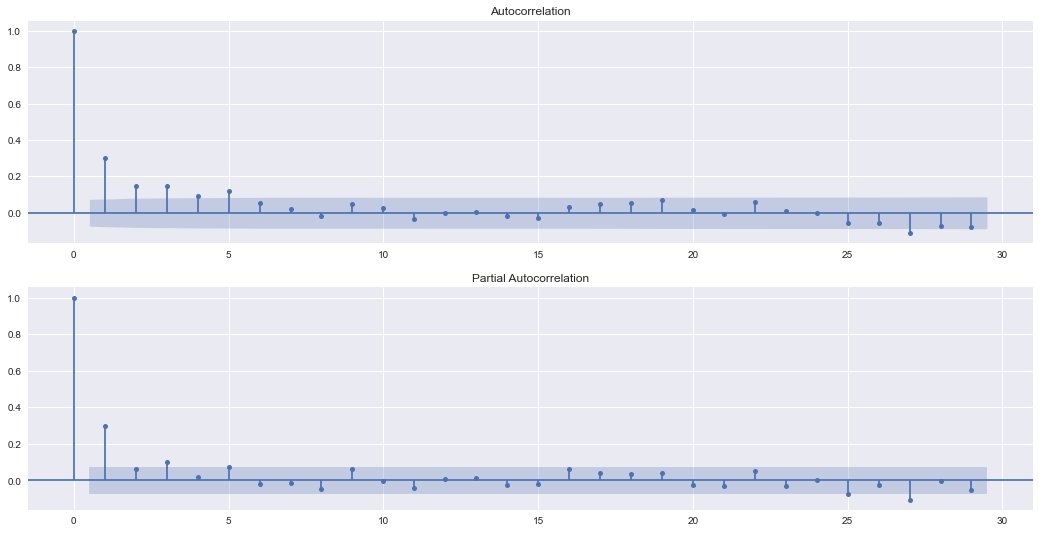

In [152]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (18, 9)

fig, ax = plt.subplots(2,1)

acf = plot_acf(pulsar6['Brightness'], ax=ax[0])
pacf = plot_pacf(pulsar6['Brightness'], ax=ax[1], method="ols")

In [153]:
acfpulsar = pd.DataFrame()
for lag in range(0,11):
    acfpulsar[f"B_lag_{lag}"] = pulsar6['Brightness'].shift(lag)

acfpulsar

B_lag_0   B_lag_1   B_lag_2   B_lag_3   B_lag_4   B_lag_5   B_lag_6  \
0    0.634671       NaN       NaN       NaN       NaN       NaN       NaN   
1    0.736945  0.634671       NaN       NaN       NaN       NaN       NaN   
2    0.693834  0.736945  0.634671       NaN       NaN       NaN       NaN   
3    1.021866  0.693834  0.736945  0.634671       NaN       NaN       NaN   
4    0.673845  1.021866  0.693834  0.736945  0.634671       NaN       NaN   
..        ...       ...       ...       ...       ...       ...       ...   
693  0.776083  0.623757  0.581248  0.555266  0.152886  0.286132  0.413354   
694  0.625382  0.776083  0.623757  0.581248  0.555266  0.152886  0.286132   
695  0.647559  0.625382  0.776083  0.623757  0.581248  0.555266  0.152886   
696  0.312449  0.647559  0.625382  0.776083  0.623757  0.581248  0.555266   
697  0.548353  0.312449  0.647559  0.625382  0.776083  0.623757  0.581248   

      B_lag_7   B_lag_8   B_lag_9  B_lag_10  
0         NaN       NaN       NaN       NaN  
1         NaN       NaN       NaN       NaN  
2         NaN       NaN       NaN       NaN  
3         NaN       NaN       NaN       NaN  
4         NaN       NaN       NaN       NaN  
..        ...       ...       ...       ...  
693  0.460095  0.541486  0.346502  0.239302  
694  0.413354  0.460095  0.541486  0.346502  
695  0.286132  0.413354  0.460095  0.541486  
696  0.152886  0.286132  0.413354  0.460095  
697  0.555266  0.152886  0.286132  0.413354  

[698 rows x 11 columns]

In [154]:
acfpulsar.corr()["B_lag_0"].values

array([ 1.        ,  0.29938402,  0.14710414,  0.15003691,  0.09455452,
        0.11800036,  0.05537751,  0.02179885, -0.01724535,  0.04863954,
        0.02621294])

Based on the auctocorrlation function (ACF) and partial autocorrelation function (PACF) above, we take every 5th observation and create a new dataset that removes some of the autocorrelation present and hopefully provides a data set that is random

In [155]:
held5ths = pulsar6[pulsar6.index % 5 == 0]

Then creating a binary column for this new dataset

In [156]:
np.savetxt(r'every5thbinarypulsar6.txt', held5ths.Binary, fmt='%d', delimiter='')
pulsar65thsbinary = held5ths.Binary.to_list()
np.savetxt(r'allpulsar6.txt', pulsar6.Binary, fmt='%d', delimiter='')

### RandTest and export

Running the RandTest on our 11 datasets:

In [157]:
import randtest

pulsar1binary = pulsar1.Binary.to_list()
pulsar2binary = pulsar2.Binary.to_list()
pulsar3binary = pulsar3.Binary.to_list()
pulsar4binary = pulsar4.Binary.to_list()
pulsar5binary = pulsar5.Binary.to_list()
pulsar6binary = pulsar6.Binary.to_list()

randtest_pulsar1 = randtest.random_score(pulsar1binary)
randtest_pulsar2 = randtest.random_score(pulsar2binary)
randtest_pulsar3 = randtest.random_score(pulsar3binary)
randtest_pulsar4 = randtest.random_score(pulsar4binary)
randtest_pulsar5 = randtest.random_score(pulsar5binary)
randtest_pulsar6 = randtest.random_score(pulsar6binary)

randtest_pulsar1_5ths = randtest.random_score(pulsar15thsbinary)
randtest_pulsar2_5ths = randtest.random_score(pulsar25thsbinary)
randtest_pulsar3_5ths = randtest.random_score(pulsar35thsbinary)
randtest_pulsar4_5ths = randtest.random_score(pulsar45thsbinary)
randtest_pulsar5_5ths = randtest.random_score(pulsar55thsbinary)
randtest_pulsar6_5ths = randtest.random_score(pulsar65thsbinary)

randtest_pulsar4_10ths = randtest.random_score(pulsar410thsbinary)

print('\033[1m' + "Pulsar 1 RandTest Results:" + '\033[0m')
print("Every Observation:", randtest_pulsar1)
print("Every 5th Observation:", randtest_pulsar1_5ths)
print("\n")

print('\033[1m' + "Pulsar 2 RantTest Results:" + '\033[0m')
print("Every Observation:", randtest_pulsar2)
print("Every 5th Observation:", randtest_pulsar2_5ths)
print("\n")

print('\033[1m' + "Pulsar 3 RantTest Results:" + '\033[0m')
print("Every Observation:", randtest_pulsar3)
print("Every 5th Observation:", randtest_pulsar3_5ths)
print("\n")

print('\033[1m' + "Pulsar 4 RantTest Results:" + '\033[0m')
print("Every Observation:", randtest_pulsar4)
print("Every 5th Observation:", randtest_pulsar4_5ths)
print("Every 10th Observation:", randtest_pulsar4_10ths)
print("\n")

print('\033[1m' + "Pulsar 5 RantTest Results:" + '\033[0m')
print("Every Observation:", randtest_pulsar5)
print("Every 5th Observation:", randtest_pulsar5_5ths)
print("\n")

print('\033[1m' + "Pulsar 6 RantTest Results:" + '\033[0m')
print("Every Observation:", randtest_pulsar6)
print("Every 5th Observation:", randtest_pulsar6_5ths)

randtestAll = [randtest_pulsar1, randtest_pulsar2, randtest_pulsar3, randtest_pulsar4, randtest_pulsar5, randtest_pulsar6]
randtest5ths = [randtest_pulsar1_5ths, randtest_pulsar2_5ths, randtest_pulsar3_5ths, randtest_pulsar4_5ths, randtest_pulsar5_5ths, randtest_pulsar6_5ths]
randtestElse = ["Null", "Null", "Null", randtest_pulsar4_10ths, "Null", "Null"]

randTestAll = pd.Series(randtestAll)
randTest5ths = pd.Series(randtest5ths)
randTestElse = pd.Series(randtestElse)

Pulsar 1 RandTest Results:
Every Observation: True
Every 5th Observation: True


Pulsar 2 RantTest Results:
Every Observation: True
Every 5th Observation: True


Pulsar 3 RantTest Results:
Every Observation: True
Every 5th Observation: True


Pulsar 4 RantTest Results:
Every Observation: True
Every 5th Observation: True
Every 10th Observation: True


Pulsar 5 RantTest Results:
Every Observation: True
Every 5th Observation: True


Pulsar 6 RantTest Results:
Every Observation: True
Every 5th Observation: True


In [158]:
frame = {'RandTestAll' : randTestAll, 'RandTest5ths' : randTest5ths, 'RandTestElse' : randTestElse}
RandtestResults = pd.DataFrame(frame)
RandtestResults.to_csv('RandTestResults.csv', index=False)

### NIST CSV Results Import

Importing the results of running the external NIST test suite so the result can be displayed within this report

In [159]:
pulsar1_all = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR1_Tested_All.csv")
pulsar1_5th = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR1_Tested_5ths.csv")
pulsar2_all = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR2_Tested_All.csv")
pulsar2_5th = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR2_Tested_5ths.csv")
pulsar3_all = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR3_Tested_All.csv")
pulsar3_5th = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR3_Tested_5ths.csv")
pulsar4_all = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR4_Tested_All.csv")
pulsar4_5th = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR4_Tested_5ths.csv")
pulsar5_all = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR5_Tested_All.csv")
pulsar5_5th = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR5_Tested_5ths.csv")
pulsar4_10th = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR4_Tested_10ths.csv")
pulsar6_all = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR6_Tested_All.csv")
pulsar6_5th = pd.read_csv("pulsaryBinaryDataResultsCSV/PULSAR6_Tested_5ths.csv")

### NIST Randomness Tests Results

Viewing the results of NIST test suite for each pulsar

#### Pulsar 1 (J0437-4715):

In [160]:
pulsar1_all

Test Name       P-Value     Outcome
0                     Frequency Test (Monobit)  1.000000e+00    Absolute
1                Frequency Test within a Block  9.050000e-08  Non-Random
2                                     Run Test  3.353164e-03  Non-Random
3               Longest Run of Ones in a Block  4.782901e-02      Random
4                      Binary Matrix Rank Test  1.020085e-01      Random
5   Discrete Fourier Transform (Spectral) Test  5.765222e-01      Random
6       Non-Overlapping Template Matching Test  4.860000e-07  Non-Random
7           Overlapping Template Matching Test  5.365440e-04  Non-Random
8          Maurer's Universal Statistical Test -1.000000e+00       Error
9                       Linear Complexity Test  8.177284e-01      Random
10                               Serial Test A  2.420000e-19  Non-Random
11                               Serial Test B  1.600000e-06  Non-Random
12                    Approximate Entropy Test  1.840000e-13  Non-Random
13              Cumulative Sums (Forward) Test  6.250000e-01      Random
14              Cumulative Sums (Reverse) Test  6.250000e-01      Random
15             Random Excursions Test State -4  1.210000e-01      Random
16             Random Excursions Test State -3  3.158609e-01      Random
17             Random Excursions Test State -2  3.590000e-01      Random
18             Random Excursions Test State -1  7.280000e-01      Random
19             Random Excursions Test State +1  2.730000e-01      Random
20             Random Excursions Test State +2  1.640000e-01      Random
21             Random Excursions Test State +3  3.070000e-01      Random
22             Random Excursions Test State +4  1.160000e-01      Random
23      Random Exursions Variant Test State -9  1.503674e-01      Random
24      Random Exursions Variant Test State -8  2.508288e-01      Random
25      Random Exursions Variant Test State -7  2.850494e-01      Random
26      Random Exursions Variant Test State -6  2.685964e-01      Random
27      Random Exursions Variant Test State -5  4.008621e-01      Random
28      Random Exursions Variant Test State -4  7.261831e-01      Random
29      Random Exursions Variant Test State -3  9.471395e-01      Random
30      Random Exursions Variant Test State -2  7.808785e-01      Random
31      Random Exursions Variant Test State -1  9.114677e-01      Random
32      Random Exursions Variant Test State +1  7.110000e-01      Random
33      Random Exursions Variant Test State +2  7.320000e-01      Random
34      Random Exursions Variant Test State +3  6.430000e-01      Random
35      Random Exursions Variant Test State +4  5.100000e-01      Random
36      Random Exursions Variant Test State +5  8.140000e-01      Random
37      Random Exursions Variant Test State +6  9.820000e-01      Random
38      Random Exursions Variant Test State +7  9.340000e-01      Random
39      Random Exursions Variant Test State +8  6.670000e-01      Random
40      Random Exursions Variant Test State +9  7.260000e-01      Random

In [161]:
pulsar1_5th

Test Name   P-Value     Outcome
0                     Frequency Test (Monobit)  0.096872      Random
1                Frequency Test within a Block  0.273011      Random
2                                     Run Test  0.295998      Random
3               Longest Run of Ones in a Block  0.143727      Random
4                      Binary Matrix Rank Test  0.858290      Random
5   Discrete Fourier Transform (Spectral) Test  0.453695      Random
6       Non-Overlapping Template Matching Test  0.424735      Random
7           Overlapping Template Matching Test  0.418207      Random
8          Maurer's Universal Statistical Test -1.000000       Error
9                       Linear Complexity Test  0.757153      Random
10                               Serial Test A  0.148533      Random
11                               Serial Test B  0.445237      Random
12                    Approximate Entropy Test  0.000145  Non-Random
13              Cumulative Sums (Forward) Test  0.072222      Random
14              Cumulative Sums (Reverse) Test  0.193743      Random
15             Random Excursions Test State -4  0.997903      Random
16             Random Excursions Test State -3  0.995330      Random
17             Random Excursions Test State -2  0.984748      Random
18             Random Excursions Test State -1  0.849145      Random
19             Random Excursions Test State +1  0.156236      Random
20             Random Excursions Test State +2  0.000354  Non-Random
21             Random Excursions Test State +3  0.000475  Non-Random
22             Random Excursions Test State +4  0.369569      Random
23      Random Exursions Variant Test State +1  0.317311      Random
24      Random Exursions Variant Test State +2  0.386476      Random
25      Random Exursions Variant Test State +3  0.013906      Random
26      Random Exursions Variant Test State +4  0.000670  Non-Random
27      Random Exursions Variant Test State +5  0.007661  Non-Random
28      Random Exursions Variant Test State +6  0.000526  Non-Random
29      Random Exursions Variant Test State +7  0.002282  Non-Random
30      Random Exursions Variant Test State +8  0.038867      Random
31      Random Exursions Variant Test State +9  0.015293      Random

#### Pulsar 2 (J0953+0755):

In [162]:
pulsar2_all

Test Name       P-Value     Outcome
0                     Frequency Test (Monobit)  9.933346e-01      Random
1                Frequency Test within a Block  9.910000e-12  Non-Random
2                                     Run Test  3.200000e-94  Non-Random
3               Longest Run of Ones in a Block  3.810000e-36  Non-Random
4                      Binary Matrix Rank Test  2.570000e-01      Random
5   Discrete Fourier Transform (Spectral) Test  6.140000e-05  Non-Random
6       Non-Overlapping Template Matching Test  3.830000e-26  Non-Random
7           Overlapping Template Matching Test  4.630000e-13  Non-Random
8          Maurer's Universal Statistical Test -1.000000e+00       Error
9                       Linear Complexity Test  5.807496e-01      Random
10                               Serial Test A  2.350000e-17  Non-Random
11                               Serial Test B  9.520000e-01      Random
12                    Approximate Entropy Test  8.310000e-34  Non-Random
13              Cumulative Sums (Forward) Test  5.600000e-01      Random
14              Cumulative Sums (Reverse) Test  5.530000e-01      Random
15             Random Excursions Test State -4  2.050000e-01      Random
16             Random Excursions Test State -3  7.680000e-03  Non-Random
17             Random Excursions Test State -2  1.610000e-03  Non-Random
18             Random Excursions Test State -1  1.780000e-02      Random
19             Random Excursions Test State +1  3.980000e-01      Random
20             Random Excursions Test State +2  4.020000e-01      Random
21             Random Excursions Test State +3  1.520000e-01      Random
22             Random Excursions Test State +4  4.760000e-01      Random
23      Random Exursions Variant Test State -9  8.054226e-01      Random
24      Random Exursions Variant Test State -8  8.514120e-01      Random
25      Random Exursions Variant Test State -7  9.198637e-01      Random
26      Random Exursions Variant Test State -6  9.651054e-01      Random
27      Random Exursions Variant Test State -5  9.037602e-01      Random
28      Random Exursions Variant Test State -4  6.808479e-01      Random
29      Random Exursions Variant Test State -3  5.164123e-01      Random
30      Random Exursions Variant Test State -2  3.147768e-01      Random
31      Random Exursions Variant Test State -1  1.467931e-01      Random
32      Random Exursions Variant Test State +1  3.100000e-01      Random
33      Random Exursions Variant Test State +2  7.060000e-01      Random
34      Random Exursions Variant Test State +3  8.460000e-01      Random
35      Random Exursions Variant Test State +4  9.560000e-01      Random
36      Random Exursions Variant Test State +5  7.170000e-01      Random
37      Random Exursions Variant Test State +6  8.100000e-01      Random
38      Random Exursions Variant Test State +7  9.680000e-01      Random
39      Random Exursions Variant Test State +8  9.550000e-01      Random
40      Random Exursions Variant Test State +9  8.880000e-01      Random

In [163]:
pulsar2_5th

Test Name   P-Value     Outcome
0                     Frequency Test (Monobit)  0.736699      Random
1                Frequency Test within a Block  0.753000      Random
2                                     Run Test  0.018694      Random
3               Longest Run of Ones in a Block  0.092363      Random
4                      Binary Matrix Rank Test  0.481248      Random
5   Discrete Fourier Transform (Spectral) Test  0.565809      Random
6       Non-Overlapping Template Matching Test  0.526000      Random
7           Overlapping Template Matching Test  0.248594      Random
8          Maurer's Universal Statistical Test -1.000000       Error
9                       Linear Complexity Test  0.543779      Random
10                               Serial Test A  0.123000      Random
11                               Serial Test B  0.224000      Random
12                    Approximate Entropy Test  0.000025  Non-Random
13              Cumulative Sums (Forward) Test  0.604000      Random
14              Cumulative Sums (Reverse) Test  0.904000      Random
15             Random Excursions Test State -4  0.332000      Random
16             Random Excursions Test State -3  0.161000      Random
17             Random Excursions Test State -2  0.625000      Random
18             Random Excursions Test State -1  0.719000      Random
19             Random Excursions Test State +1  0.008430  Non-Random
20             Random Excursions Test State +2  0.000040  Non-Random
21             Random Excursions Test State +3  0.152000      Random
22             Random Excursions Test State +4  0.383000      Random
23      Random Exursions Variant Test State -5  0.226919      Random
24      Random Exursions Variant Test State -4  0.237548      Random
25      Random Exursions Variant Test State -3  0.263552      Random
26      Random Exursions Variant Test State -2  0.193931      Random
27      Random Exursions Variant Test State -1  0.133614      Random
28      Random Exursions Variant Test State +1  0.261000      Random
29      Random Exursions Variant Test State +2  0.516000      Random
30      Random Exursions Variant Test State +3  0.576000      Random
31      Random Exursions Variant Test State +4  0.450000      Random
32      Random Exursions Variant Test State +5  0.739000      Random
33      Random Exursions Variant Test State +6  0.792000      Random
34      Random Exursions Variant Test State +7  0.533000      Random
35      Random Exursions Variant Test State +8  0.561000      Random
36      Random Exursions Variant Test State +9  0.649000      Random

#### Pulsar 3 (J0835-4510):

In [164]:
pulsar3_all

Test Name   P-Value Outcome
0                     Frequency Test (Monobit)  0.978133  Random
1                Frequency Test within a Block  0.843000  Random
2                                     Run Test  0.051600  Random
3               Longest Run of Ones in a Block  0.206000  Random
4                      Binary Matrix Rank Test  0.694000  Random
5   Discrete Fourier Transform (Spectral) Test  0.655000  Random
6       Non-Overlapping Template Matching Test  0.771000  Random
7           Overlapping Template Matching Test  0.887000  Random
8          Maurer's Universal Statistical Test -1.000000   Error
9                       Linear Complexity Test  0.320837  Random
10                               Serial Test A  0.876000  Random
11                               Serial Test B  0.553000  Random
12                    Approximate Entropy Test  0.767000  Random
13              Cumulative Sums (Forward) Test  0.943000  Random
14              Cumulative Sums (Reverse) Test  0.926000  Random
15             Random Excursions Test State -4  0.339000  Random
16             Random Excursions Test State -3  0.590000  Random
17             Random Excursions Test State -2  0.573000  Random
18             Random Excursions Test State -1  0.590000  Random
19             Random Excursions Test State +1  0.491000  Random
20             Random Excursions Test State +2  0.565000  Random
21             Random Excursions Test State +3  0.448000  Random
22             Random Excursions Test State +4  0.643000  Random
23      Random Exursions Variant Test State -9  0.215330  Random
24      Random Exursions Variant Test State -8  0.180652  Random
25      Random Exursions Variant Test State -7  0.150421  Random
26      Random Exursions Variant Test State -6  0.174968  Random
27      Random Exursions Variant Test State -5  0.232254  Random
28      Random Exursions Variant Test State -4  0.286278  Random
29      Random Exursions Variant Test State -3  0.322716  Random
30      Random Exursions Variant Test State -2  0.332797  Random
31      Random Exursions Variant Test State -1  0.541866  Random
32      Random Exursions Variant Test State +1  0.493000  Random
33      Random Exursions Variant Test State +2  0.509000  Random
34      Random Exursions Variant Test State +3  0.759000  Random
35      Random Exursions Variant Test State +4  0.863000  Random
36      Random Exursions Variant Test State +5  0.780000  Random
37      Random Exursions Variant Test State +6  0.629000  Random
38      Random Exursions Variant Test State +7  0.410000  Random
39      Random Exursions Variant Test State +8  0.288000  Random
40      Random Exursions Variant Test State +9  0.309000  Random

In [165]:
pulsar3_5th

Test Name   P-Value     Outcome
0                     Frequency Test (Monobit)  0.951201      Random
1                Frequency Test within a Block  0.925000      Random
2                                     Run Test  0.126000      Random
3               Longest Run of Ones in a Block  0.957000      Random
4                      Binary Matrix Rank Test -1.000000       Error
5   Discrete Fourier Transform (Spectral) Test  0.003660  Non-Random
6       Non-Overlapping Template Matching Test  1.000000      Random
7           Overlapping Template Matching Test -1.000000       Error
8          Maurer's Universal Statistical Test -1.000000       Error
9                       Linear Complexity Test -1.000000       Error
10                               Serial Test A  0.499000      Random
11                               Serial Test B  0.499000      Random
12                    Approximate Entropy Test  1.000000    Absolute
13              Cumulative Sums (Forward) Test  0.763000      Random
14              Cumulative Sums (Reverse) Test  0.705000      Random
15             Random Excursions Test State -4  0.886000      Random
16             Random Excursions Test State -3  0.347000      Random
17             Random Excursions Test State -2  0.735000      Random
18             Random Excursions Test State -1  0.700000      Random
19             Random Excursions Test State +1  0.659000      Random
20             Random Excursions Test State +2  0.258000      Random
21             Random Excursions Test State +3  0.018600      Random
22             Random Excursions Test State +4  0.783000      Random
23      Random Exursions Variant Test State -9  0.490920      Random
24      Random Exursions Variant Test State -8  0.463355      Random
25      Random Exursions Variant Test State -7  0.410205      Random
26      Random Exursions Variant Test State -6  0.413686      Random
27      Random Exursions Variant Test State -5  0.438578      Random
28      Random Exursions Variant Test State -4  0.406813      Random
29      Random Exursions Variant Test State -3  0.603332      Random
30      Random Exursions Variant Test State -2  0.765594      Random
31      Random Exursions Variant Test State -1  0.605577      Random
32      Random Exursions Variant Test State +1  0.699000      Random
33      Random Exursions Variant Test State +2  0.502000      Random
34      Random Exursions Variant Test State +3  0.326000      Random
35      Random Exursions Variant Test State +4  0.262000      Random
36      Random Exursions Variant Test State +5  0.263000      Random
37      Random Exursions Variant Test State +6  0.259000      Random
38                                         NaN       NaN         NaN
39                                         NaN       NaN         NaN
40                                         NaN       NaN         NaN

#### Pulsar 4 (J1243-6423):

In [166]:
pulsar4_all

Test Name       P-Value     Outcome
0                     Frequency Test (Monobit)  9.812939e-01      Random
1                Frequency Test within a Block  3.910000e-53  Non-Random
2                                     Run Test  3.420000e-21  Non-Random
3               Longest Run of Ones in a Block  3.930000e-08  Non-Random
4                      Binary Matrix Rank Test  6.940000e-01      Random
5   Discrete Fourier Transform (Spectral) Test  1.820000e-02      Random
6       Non-Overlapping Template Matching Test  7.120000e-02      Random
7           Overlapping Template Matching Test  2.960000e-01      Random
8          Maurer's Universal Statistical Test -1.000000e+00       Error
9                       Linear Complexity Test  4.620000e-01      Random
10                               Serial Test A  0.000000e+00  Non-Random
11                               Serial Test B  0.000000e+00  Non-Random
12                    Approximate Entropy Test  2.100000e-12  Non-Random
13              Cumulative Sums (Forward) Test  1.040000e-09  Non-Random
14              Cumulative Sums (Reverse) Test  8.930000e-10  Non-Random
15             Random Excursions Test State -4  9.730000e-01      Random
16             Random Excursions Test State -3  9.450000e-01      Random
17             Random Excursions Test State -2  8.490000e-01      Random
18             Random Excursions Test State -1  3.060000e-01      Random
19             Random Excursions Test State +1  9.310000e-01      Random
20             Random Excursions Test State +2  5.080000e-01      Random
21             Random Excursions Test State +3  1.770000e-01      Random
22             Random Excursions Test State +4  1.180000e-02      Random
23      Random Exursions Variant Test State -1  5.637029e-01      Random
24      Random Exursions Variant Test State +1  3.860000e-01      Random
25      Random Exursions Variant Test State +2  6.170000e-01      Random
26      Random Exursions Variant Test State +3  6.990000e-01      Random
27      Random Exursions Variant Test State +4  8.270000e-01      Random
28      Random Exursions Variant Test State +5  8.470000e-01      Random
29      Random Exursions Variant Test State +6  7.280000e-01      Random
30      Random Exursions Variant Test State +7  8.100000e-01      Random
31      Random Exursions Variant Test State +8  8.810000e-01      Random
32      Random Exursions Variant Test State +9  8.340000e-01      Random

In [167]:
pulsar4_5th

Test Name       P-Value     Outcome
0                     Frequency Test (Monobit)  8.339354e-01      Random
1                Frequency Test within a Block  3.340000e-03  Non-Random
2                                     Run Test  3.350000e-03  Non-Random
3               Longest Run of Ones in a Block  4.350000e-01      Random
4                      Binary Matrix Rank Test -1.000000e+00       Error
5   Discrete Fourier Transform (Spectral) Test  3.120000e-01      Random
6       Non-Overlapping Template Matching Test  1.000000e+00    Absolute
7           Overlapping Template Matching Test -1.000000e+00       Error
8          Maurer's Universal Statistical Test -1.000000e+00       Error
9                       Linear Complexity Test -1.000000e+00       Error
10                               Serial Test A  0.000000e+00  Non-Random
11                               Serial Test B  0.000000e+00  Non-Random
12                    Approximate Entropy Test  1.000000e+00    Absolute
13              Cumulative Sums (Forward) Test  3.970000e-03  Non-Random
14              Cumulative Sums (Reverse) Test  7.880000e-03  Non-Random
15             Random Excursions Test State -4  9.980000e-01      Random
16             Random Excursions Test State -3  9.950000e-01      Random
17             Random Excursions Test State -2  9.850000e-01      Random
18             Random Excursions Test State -1  8.490000e-01      Random
19             Random Excursions Test State +1  6.840000e-03  Non-Random
20             Random Excursions Test State +2  2.980000e-04  Non-Random
21             Random Excursions Test State +3  3.550000e-04  Non-Random
22             Random Excursions Test State +4  1.220000e-04  Non-Random
23      Random Exursions Variant Test State +1  1.240000e-02      Random
24      Random Exursions Variant Test State +2  1.490000e-05  Non-Random
25      Random Exursions Variant Test State +3  2.700000e-07  Non-Random
26      Random Exursions Variant Test State +4  1.570000e-04  Non-Random
27      Random Exursions Variant Test State +5  6.680000e-02      Random
28      Random Exursions Variant Test State +6  1.320000e-01      Random
29      Random Exursions Variant Test State +7  3.750000e-02      Random
30      Random Exursions Variant Test State +8  5.280000e-02      Random
31      Random Exursions Variant Test State +9  2.750000e-01      Random

In [168]:
pulsar4_10th

Test Name   P-Value     Outcome
0                     Frequency Test (Monobit)  0.656501      Random
1                Frequency Test within a Block  0.021600      Random
2                                     Run Test  0.001920  Non-Random
3               Longest Run of Ones in a Block  0.326000      Random
4                      Binary Matrix Rank Test -1.000000       Error
5   Discrete Fourier Transform (Spectral) Test  0.760000      Random
6       Non-Overlapping Template Matching Test  1.000000    Absolute
7           Overlapping Template Matching Test -1.000000       Error
8          Maurer's Universal Statistical Test -1.000000       Error
9                       Linear Complexity Test -1.000000       Error
10                               Serial Test A  0.000000  Non-Random
11                               Serial Test B  0.000000  Non-Random
12                    Approximate Entropy Test  1.000000    Absolute
13              Cumulative Sums (Forward) Test  0.023500      Random
14              Cumulative Sums (Reverse) Test  0.075900      Random
15             Random Excursions Test State -4  0.905000      Random
16             Random Excursions Test State -3  0.324000      Random
17             Random Excursions Test State -2  0.768000      Random
18             Random Excursions Test State -1  0.394000      Random
19             Random Excursions Test State +1  0.836000      Random
20             Random Excursions Test State +2  0.481000      Random
21             Random Excursions Test State +3  0.331000      Random
22             Random Excursions Test State +4  0.067000      Random
23      Random Exursions Variant Test State -3  0.504501      Random
24      Random Exursions Variant Test State -2  0.711923      Random
25      Random Exursions Variant Test State -1  0.831170      Random
26      Random Exursions Variant Test State +1  1.000000    Absolute
27      Random Exursions Variant Test State +2  0.902000      Random
28      Random Exursions Variant Test State +3  0.924000      Random
29      Random Exursions Variant Test State +4  0.872000      Random
30      Random Exursions Variant Test State +5  0.570000      Random
31      Random Exursions Variant Test State +6  0.563000      Random
32      Random Exursions Variant Test State +7  0.636000      Random
33      Random Exursions Variant Test State +8  0.741000      Random
34      Random Exursions Variant Test State +9  0.796000      Random


#### Pulsar 5 (J1456-6843):

In [169]:
pulsar5_all

Test Name   P-Value     Outcome
0                     Frequency Test (Monobit)  0.977150      Random
1                Frequency Test within a Block  0.039800      Random
2                                     Run Test  0.000020  Non-Random
3               Longest Run of Ones in a Block  0.085500      Random
4                      Binary Matrix Rank Test  0.694000      Random
5   Discrete Fourier Transform (Spectral) Test  0.064800      Random
6       Non-Overlapping Template Matching Test  0.032300      Random
7           Overlapping Template Matching Test  0.296000      Random
8          Maurer's Universal Statistical Test -1.000000       Error
9                       Linear Complexity Test  0.029600      Random
10                               Serial Test A  0.853000      Random
11                               Serial Test B  0.963000      Random
12                    Approximate Entropy Test  0.956000      Random
13              Cumulative Sums (Forward) Test  0.761000      Random
14              Cumulative Sums (Reverse) Test  0.761000      Random
15             Random Excursions Test State -4  0.000254  Non-Random
16             Random Excursions Test State -3  0.019100      Random
17             Random Excursions Test State -2  0.162000      Random
18             Random Excursions Test State -1  0.067300      Random
19             Random Excursions Test State +1  0.941000      Random
20             Random Excursions Test State +2  0.951000      Random
21             Random Excursions Test State +3  0.155000      Random
22             Random Excursions Test State +4  0.027100      Random
23      Random Exursions Variant Test State -9  0.867859      Random
24      Random Exursions Variant Test State -8  0.790482      Random
25      Random Exursions Variant Test State -7  0.668588      Random
26      Random Exursions Variant Test State -6  0.569494      Random
27      Random Exursions Variant Test State -5  0.331137      Random
28      Random Exursions Variant Test State -4  0.194835      Random
29      Random Exursions Variant Test State -3  0.145052      Random
30      Random Exursions Variant Test State -2  0.092327      Random
31      Random Exursions Variant Test State -1  0.229949      Random
32      Random Exursions Variant Test State +1  0.170000      Random
33      Random Exursions Variant Test State +2  0.166000      Random
34      Random Exursions Variant Test State +3  0.645000      Random
35      Random Exursions Variant Test State +4  1.000000    Absolute
36      Random Exursions Variant Test State +5  0.775000      Random
37      Random Exursions Variant Test State +6  0.642000      Random
38      Random Exursions Variant Test State +7  0.812000      Random
39      Random Exursions Variant Test State +8  0.965000      Random
40      Random Exursions Variant Test State +9  0.835000      Random

In [170]:
pulsar5_5th

Test Name   P-Value   Outcome
0                     Frequency Test (Monobit)  0.898120    Random
1                Frequency Test within a Block  0.860000    Random
2                                     Run Test  0.095800    Random
3               Longest Run of Ones in a Block  0.693000    Random
4                      Binary Matrix Rank Test -1.000000     Error
5   Discrete Fourier Transform (Spectral) Test  0.217000    Random
6       Non-Overlapping Template Matching Test  1.000000  Absolute
7           Overlapping Template Matching Test -1.000000     Error
8          Maurer's Universal Statistical Test -1.000000     Error
9                       Linear Complexity Test -1.000000     Error
10                               Serial Test A  0.853000    Random
11                               Serial Test B  0.932000    Random
12                    Approximate Entropy Test  1.000000  Absolute
13              Cumulative Sums (Forward) Test  0.894000    Random
14              Cumulative Sums (Reverse) Test  0.786000    Random
15             Random Excursions Test State -4  0.728000    Random
16             Random Excursions Test State -3  0.900000    Random
17             Random Excursions Test State -2  0.755000    Random
18             Random Excursions Test State -1  0.968000    Random
19             Random Excursions Test State +1  0.383000    Random
20             Random Excursions Test State +2  0.542000    Random
21             Random Excursions Test State +3  0.568000    Random
22             Random Excursions Test State +4  0.796000    Random
23      Random Exursions Variant Test State -9  0.638822    Random
24      Random Exursions Variant Test State -8  8.415830    Random
25      Random Exursions Variant Test State -7  0.382103    Random
26      Random Exursions Variant Test State -6  0.500924    Random
27      Random Exursions Variant Test State -5  0.630192    Random
28      Random Exursions Variant Test State -4  0.655119    Random
29      Random Exursions Variant Test State -3  0.597154    Random
30      Random Exursions Variant Test State -2  0.820090    Random
31      Random Exursions Variant Test State -1  0.599426    Random
32      Random Exursions Variant Test State +1  0.237000    Random
33      Random Exursions Variant Test State +2  0.225000    Random
34      Random Exursions Variant Test State +3  0.159000    Random
35      Random Exursions Variant Test State +4  0.234000    Random
36      Random Exursions Variant Test State +5  0.294000    Random
37      Random Exursions Variant Test State +6  0.285000    Random
38      Random Exursions Variant Test State +7  0.382000    Random
39      Random Exursions Variant Test State +8  0.416000    Random
40      Random Exursions Variant Test State +9  0.390000    Random

#### Pulsar 6 (J1644-4559):

In [171]:
pulsar6_all

Test Name   P-Value     Outcome
0                     Frequency Test (Monobit)  1.000000    Absolute
1                Frequency Test within a Block  0.836000      Random
2                                     Run Test  0.000011  Non-Random
3               Longest Run of Ones in a Block  0.000178  Non-Random
4                      Binary Matrix Rank Test -1.000000       Error
5   Discrete Fourier Transform (Spectral) Test  0.218000      Random
6       Non-Overlapping Template Matching Test  0.087500      Random
7           Overlapping Template Matching Test -1.000000       Error
8          Maurer's Universal Statistical Test -1.000000       Error
9                       Linear Complexity Test -1.000000       Error
10                               Serial Test A  0.356000      Random
11                               Serial Test B  0.697000      Random
12                    Approximate Entropy Test  1.000000    Absolute
13              Cumulative Sums (Forward) Test  0.679000      Random
14              Cumulative Sums (Reverse) Test  0.679000      Random
15             Random Excursions Test State -4  0.196000      Random
16             Random Excursions Test State -3  0.398000      Random
17             Random Excursions Test State -2  0.760000      Random
18             Random Excursions Test State -1  0.845000      Random
19             Random Excursions Test State +1  0.272000      Random
20             Random Excursions Test State +2  0.135000      Random
21             Random Excursions Test State +3  0.076700      Random
22             Random Excursions Test State +4  0.002160  Non-Random
23      Random Exursions Variant Test State -9  0.324324      Random
24      Random Exursions Variant Test State -8  0.338728      Random
25      Random Exursions Variant Test State -7  0.388747      Random
26      Random Exursions Variant Test State -6  0.449177      Random
27      Random Exursions Variant Test State -5  0.449063      Random
28      Random Exursions Variant Test State -4  0.366256      Random
29      Random Exursions Variant Test State -3  0.335979      Random
30      Random Exursions Variant Test State -2  0.407626      Random
31      Random Exursions Variant Test State -1  0.719918      Random
32      Random Exursions Variant Test State +1  0.720000      Random
33      Random Exursions Variant Test State +2  0.730000      Random
34      Random Exursions Variant Test State +3  0.364000      Random
35      Random Exursions Variant Test State +4  0.442000      Random
36      Random Exursions Variant Test State +5  0.605000      Random
37      Random Exursions Variant Test State +6  0.719000      Random
38      Random Exursions Variant Test State +7  0.947000      Random
39      Random Exursions Variant Test State +8  0.975000      Random
40      Random Exursions Variant Test State +9  0.908000      Random

In [143]:
pulsar6_5th

Test Name   P-Value   Outcome
0                     Frequency Test (Monobit)  0.498962    Random
1                Frequency Test within a Block  0.596000    Random
2                                     Run Test  0.835000    Random
3               Longest Run of Ones in a Block  0.833000    Random
4                      Binary Matrix Rank Test -1.000000     Error
5   Discrete Fourier Transform (Spectral) Test  0.698000    Random
6       Non-Overlapping Template Matching Test  1.000000    Random
7           Overlapping Template Matching Test -1.000000     Error
8          Maurer's Universal Statistical Test -1.000000     Error
9                       Linear Complexity Test -1.000000     Error
10                               Serial Test A  0.499000    Random
11                               Serial Test B  0.098400    Random
12                    Approximate Entropy Test  1.000000  Absolute
13              Cumulative Sums (Forward) Test  0.473000    Random
14              Cumulative Sums (Reverse) Test  0.849000    Random
15             Random Excursions Test State -4  0.431000    Random
16             Random Excursions Test State -3  0.494000    Random
17             Random Excursions Test State -2  0.221000    Random
18             Random Excursions Test State -1  0.149000    Random
19             Random Excursions Test State +1  0.570000    Random
20             Random Excursions Test State +2  0.801000    Random
21             Random Excursions Test State +3  0.924000    Random
22             Random Excursions Test State +4  0.963000    Random
23      Random Exursions Variant Test State -9  0.845815    Random
24      Random Exursions Variant Test State -8  0.944984    Random
25      Random Exursions Variant Test State -7  0.766848    Random
26      Random Exursions Variant Test State -6  0.808976    Random
27      Random Exursions Variant Test State -5  0.929013    Random
28      Random Exursions Variant Test State -4  0.613505    Random
29      Random Exursions Variant Test State -3  0.473289    Random
30      Random Exursions Variant Test State -2  0.643429    Random
31      Random Exursions Variant Test State -1  0.422678    Random
32      Random Exursions Variant Test State +1  0.109000    Random

In [148]:
# Code for results table
index = pd.MultiIndex.from_product([['Pulsar 1', 'Pulsar 2', 'Pulsar 3', 'Pulsar 4', 'Pulsar 5', 'Pulsar 6']])
columns = ['Every Observation','Every 5th Observation', "Every 10th Observation"]
data = [["Not Random", "Random", "N/A"],
        ["Not Random", "Random", "N/A"],
        ["Random", "Random", "N/A"],
        ["Not Random", "Not Random", "Random"],
        ["Random", "Random", "N/A"],
        ["Not Random", "Random", "N/A"]]
all_df = pd.DataFrame(data, index=index, columns=columns)
def highlight_cells(s):

    if s == 'Random':
        color = '#71b06b' # green
    elif s == 'Not Random':
        color = '#cf7672' # red
    else:
        color = '#999999' # grey
    return 'background-color: % s' % color

## Conclusion

To determine the randomness in pulsar emissions, the data collected by the CSIRO from the Parkes Observatory was explored, and then manipulated into binary sequences based on each pulsar’s median. Furthermore, the autocorrelation function (ACF) was analysed for each pulsar to determine if there was any autocorrelation in the brightness that would effect the randomness of the observations. To remove this autocorrelaton, and hopefully achieve more random data, more datasets were created with every nth observation, where n was adjusted based on findings from the ACF. These sequences were then run through the NIST statistical suite  as well as RandTest to determine whether they were truly random.

The results of these randomness tests have been studied and an overall determination of the randomness of each dataset on each of the 6 pulsars has been outlined below.

| | Every Observation | Every 5th Obsercation | Every 10th Observation |
|--------------|-----:|-----------:|-----------:|
| **Pulsar 1** | Not Random | Random | N/A |
| **Pulsar 2** | Not Random | Random | N/A |
| **Pulsar 3** | Random | Random | N/A |
| **Pulsar 4** | Not Random | Not Random | Random |
| **Pulsar 5** | Random | Random | N/A |
| **Pulsar 6** | Not Random | Random | N/A |

It can be observed that for the tests performed on all observations, only Pulsar 3 and Pulsar 5 were deemed to be random. In comparison, Pulsar 1, 2, 3, 5, and 6 were determined to be random when taking every 5th observation, with Pulsar 4 still being non-random. However, when taking every 10th observation for Pulsar 4, we do see a sequence that can be considered random. Hence, by finding the appropriate time scale correlation for each pulsar, we were able to produce a sequence that is random.

This investigation focuses on utilising the measure of pulsar emission intensities to generate random number sequences that can be used for cryptographic, commercial, and defence purposes. Through this study, it has been found that the given pulsars do pass statistical randomness testing when accounting for their correlation scale, and therefore, may provide an unbiased source for random number generation.

In [ ]:
# Code for results table
#index = pd.MultiIndex.from_product([['Pulsar 1', 'Pulsar 2', 'Pulsar 3', 'Pulsar 4', 'Pulsar 5', 'Pulsar 6']])
#columns = ['Every Observation','Every 5th Observation', "Every 10th Observation"]
#data = [["Not Random", "Random", "N/A"],
        ["Not Random", "Random", "N/A"],
        ["Random", "Random", "N/A"],
        ["Not Random", "Not Random", "Random"],
        ["Random", "Random", "N/A"],
        ["Not Random", "Random", "N/A"]]
#all_df = pd.DataFrame(data, index=index, columns=columns)
#def highlight_cells(s):

#    if s == 'Random':
#        color = '#71b06b' # green
#    elif s == 'Not Random':
#        color = '#cf7672' # red
#   else:
#       color = '#999999' # grey
#    return 'background-color: % s' % #color

#display(all_df.style.applymap(highlight_cells))